In [ ]:
# imports

import numpy as np
import scipy
import pickle
import matplotlib
import matplotlib.pyplot as plt
import copy
import logging
import itertools
from datetime import datetime
datet = datetime.now().strftime("%d%m_%H%M")
import os
import sys
sys.path.insert(0, os.path.abspath('..')) 

from scripts.fitting_functions import *
from scripts.plotting_functions import *
from scripts.simulation_functions import *

%matplotlib inline
plt.rcParams.update({
    'figure.dpi': 200,
    'text.usetex': False, 
    'mathtext.fontset': 'custom',              
    'mathtext.rm': 'Times New Roman',          
    'mathtext.it': 'Times New Roman:italic',   
    'mathtext.bf': 'Times New Roman:bold',      
    'axes.unicode_minus': False,                
    'font.family': 'sans-serif',               
    'font.sans-serif': ['Arial'],   
    'font.size': 14          
})

%load_ext autoreload
%autoreload 2


In [ ]:
# load data

data = scipy.io.loadmat('../data/Data_cell_types_small_size.mat')
keys = list(data.keys())
data_keys = keys[3:7]
data_fit_list = [data[key] for key in data_keys]
contrasts = data[keys[-1]]
c_range = contrasts.flatten()/100 # [0, 0.06, 0.12, 0.25, 0.5, 1]

N_datapoints = np.array([len(cell_type) for cell_type in data_fit_list])
means = np.array([np.mean(cell_type, axis=0) for cell_type in data_fit_list])
covs = np.array([np.cov(np.array(cell_type).T) for cell_type in data_fit_list])
sems = np.array([np.sqrt(np.diag(cov) / N_datapoints[i]) for i, cov in enumerate(covs)])

# load params/fits from file

with open('../data/fits_cnd1_top200_250102_125616.pkl', 'rb') as f: # fits_top400_2401_1811.pkl
    top_fits, top_params, top_likelihoods = pickle.load(f)

# global consts for sim

T_sim = 10 # sim time (wall clock)
dt = 1e-4 # sim time step
TAU = np.diag([0.02,0.01,0.01,0.01]) # time consts (20ms E, 10ms I)
tau_noise = 2e-2 # OU only (note 50ms 'slow noise' in Hennequin paper)
sigma_noise = 1e-2 # noise magnitude
init_perturb_mag = 5e-3 # initial perturbation magnitude

# select fit, contrast

k = 7 # fit index
contrast = 1 # contrast from c_range
fit = top_fits[k]
(W,h1,h0) = top_params[k]
c_ind = np.where(c_range == contrast)[0][0]
r_fp = fit[:,c_ind] # fixed point rates at fit, contrast


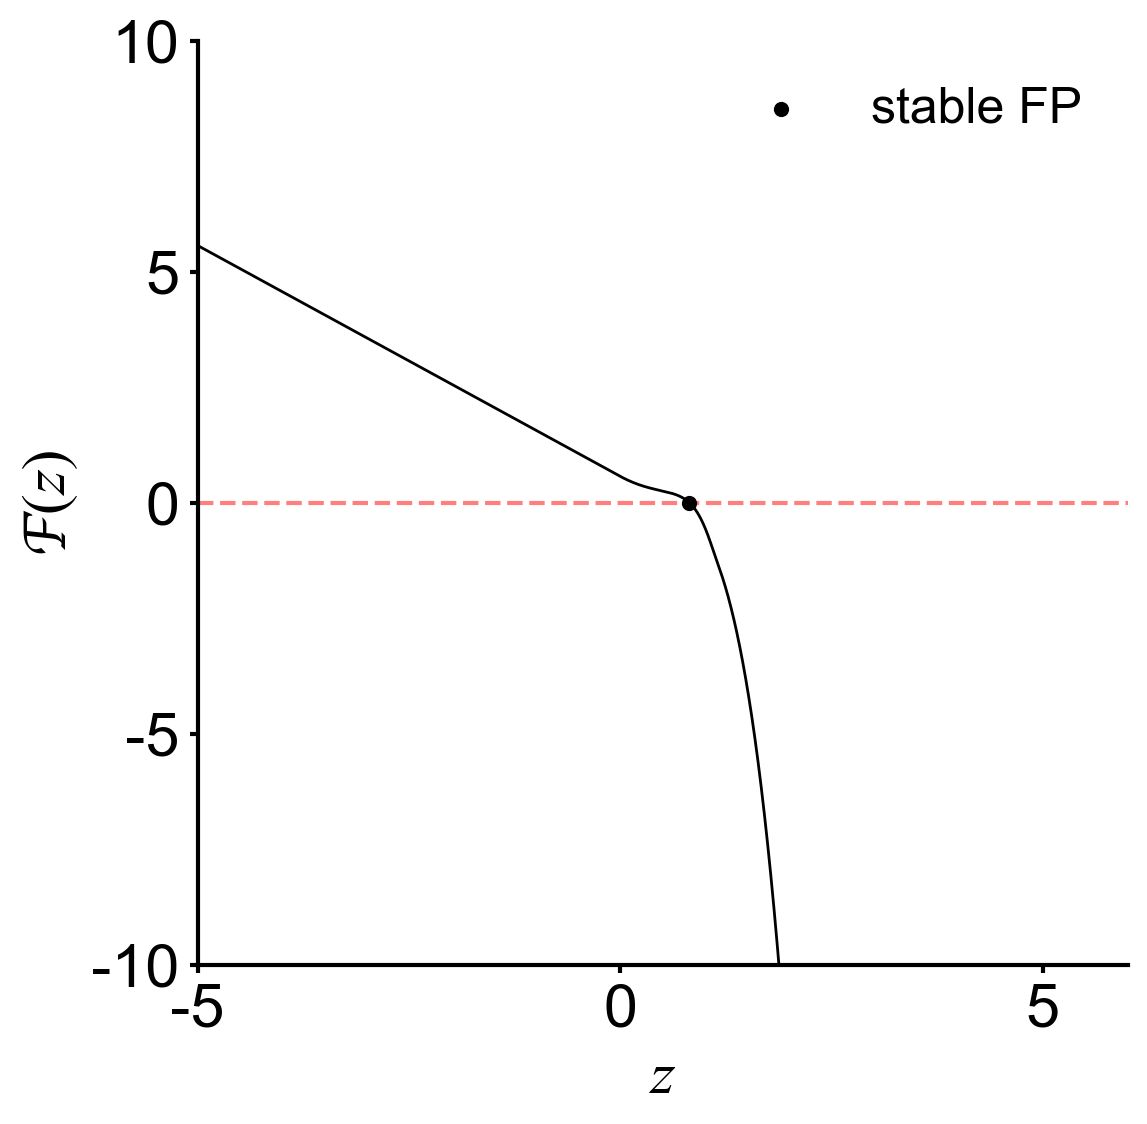

In [ ]:
# plot polynomial for selected parameters (visualise FP)

h_ext = np.array([0,0,0,0.1]) # stable
contrast = 1
fit_condition = 1 # fit condition for data
h0_tot = h0 + h_ext
plot_params = (W, h1, h0_tot)
N_z = int(1e4)
z_lims = [-5, 5]
y_lims = [-10, 10]

fig, _, _ = plot_polynomial(plot_params, c_range, means, contrast, h_ext, TAU, k, z_lims=z_lims, y_lims=y_lims, fit_condition=fit_condition, N_z=N_z, savefig=False)

## simulations at fixed points

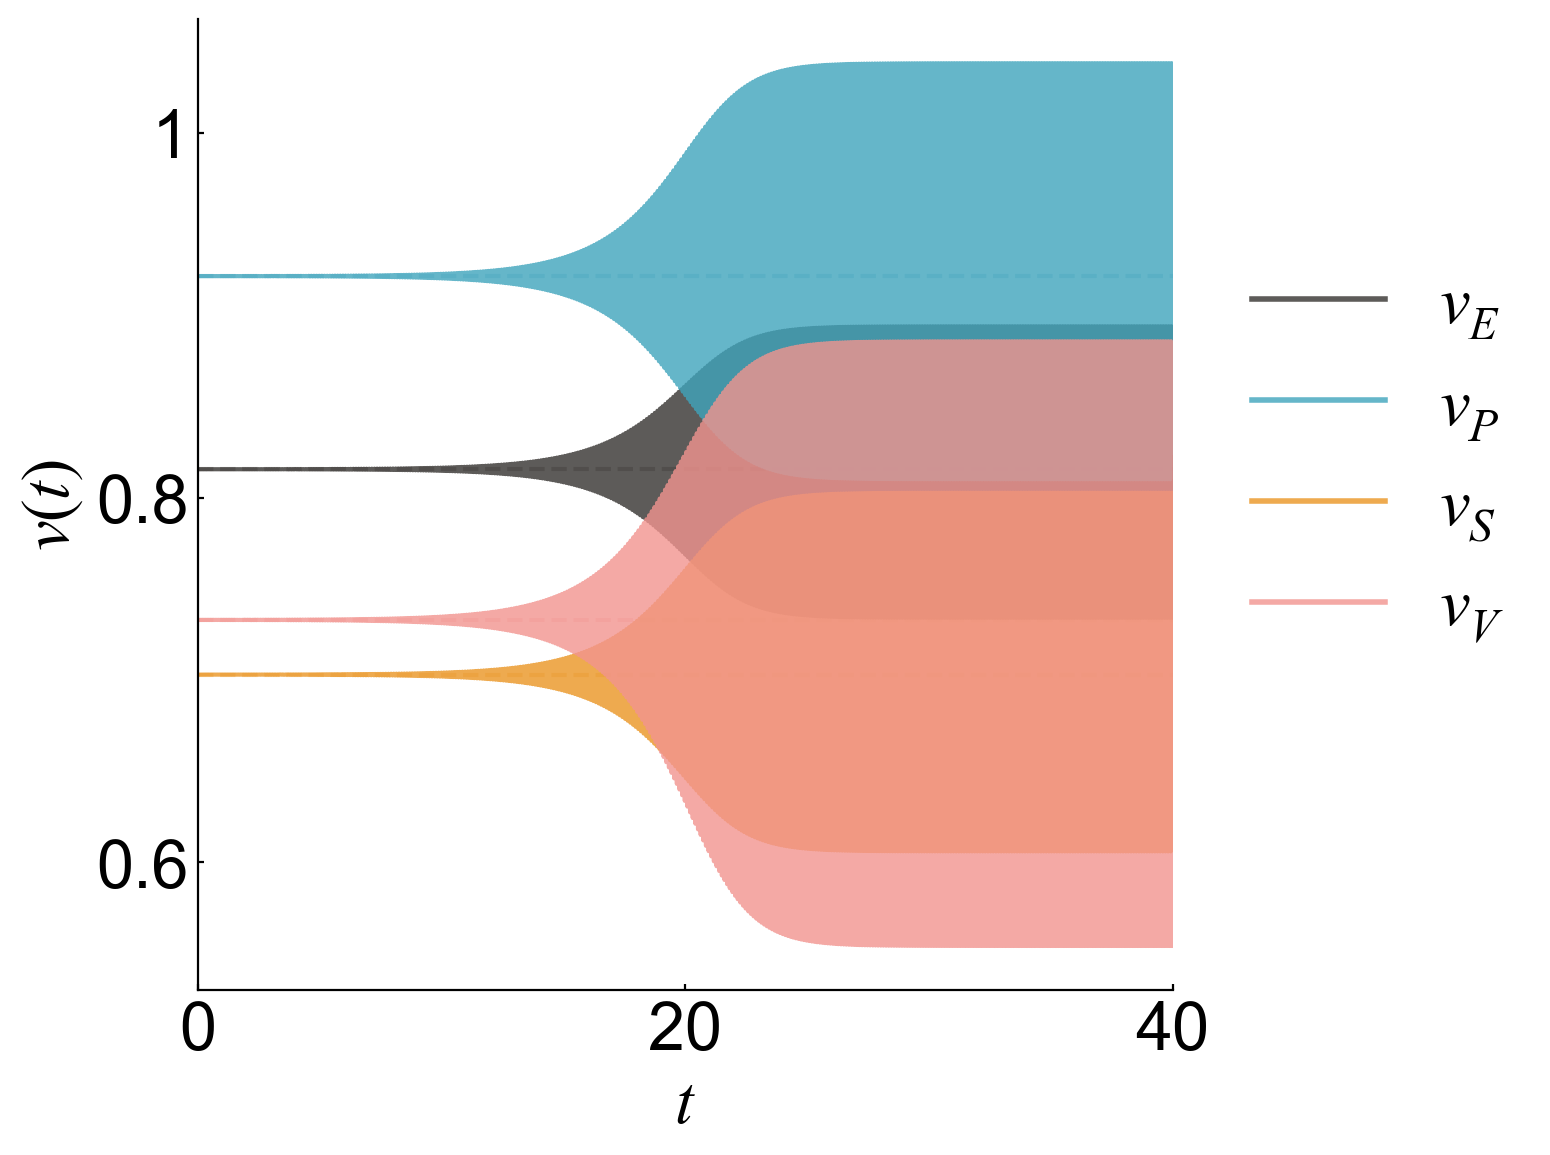

In [ ]:
# simulate full system with perturbation

T_sim = 40
variable = 'voltage' # voltage or rate
noise_type = 'none' # none, OU or white (voltage only)
h_ext = np.array([0,0,0,0.12]) # unstable
h0_tot = h0 + h_ext
h_tot = h1 * contrast + h0_tot

r_fp, _ = get_ss(r_fp, W, h1, h0_tot, contrast, z_lims=z_lims, N_z=N_z)
x_trajectory, _ = sim_global(r_fp, init_perturb_mag, W, h_tot, TAU, variable, T_sim=T_sim, dt=dt)
fig = plot_trajectory(x_trajectory, r_fp, W, h_ext, h_tot, variable, contrast, k, T_sim=T_sim, dt=dt, sim_type='global', noise_type=noise_type, savefig=False)


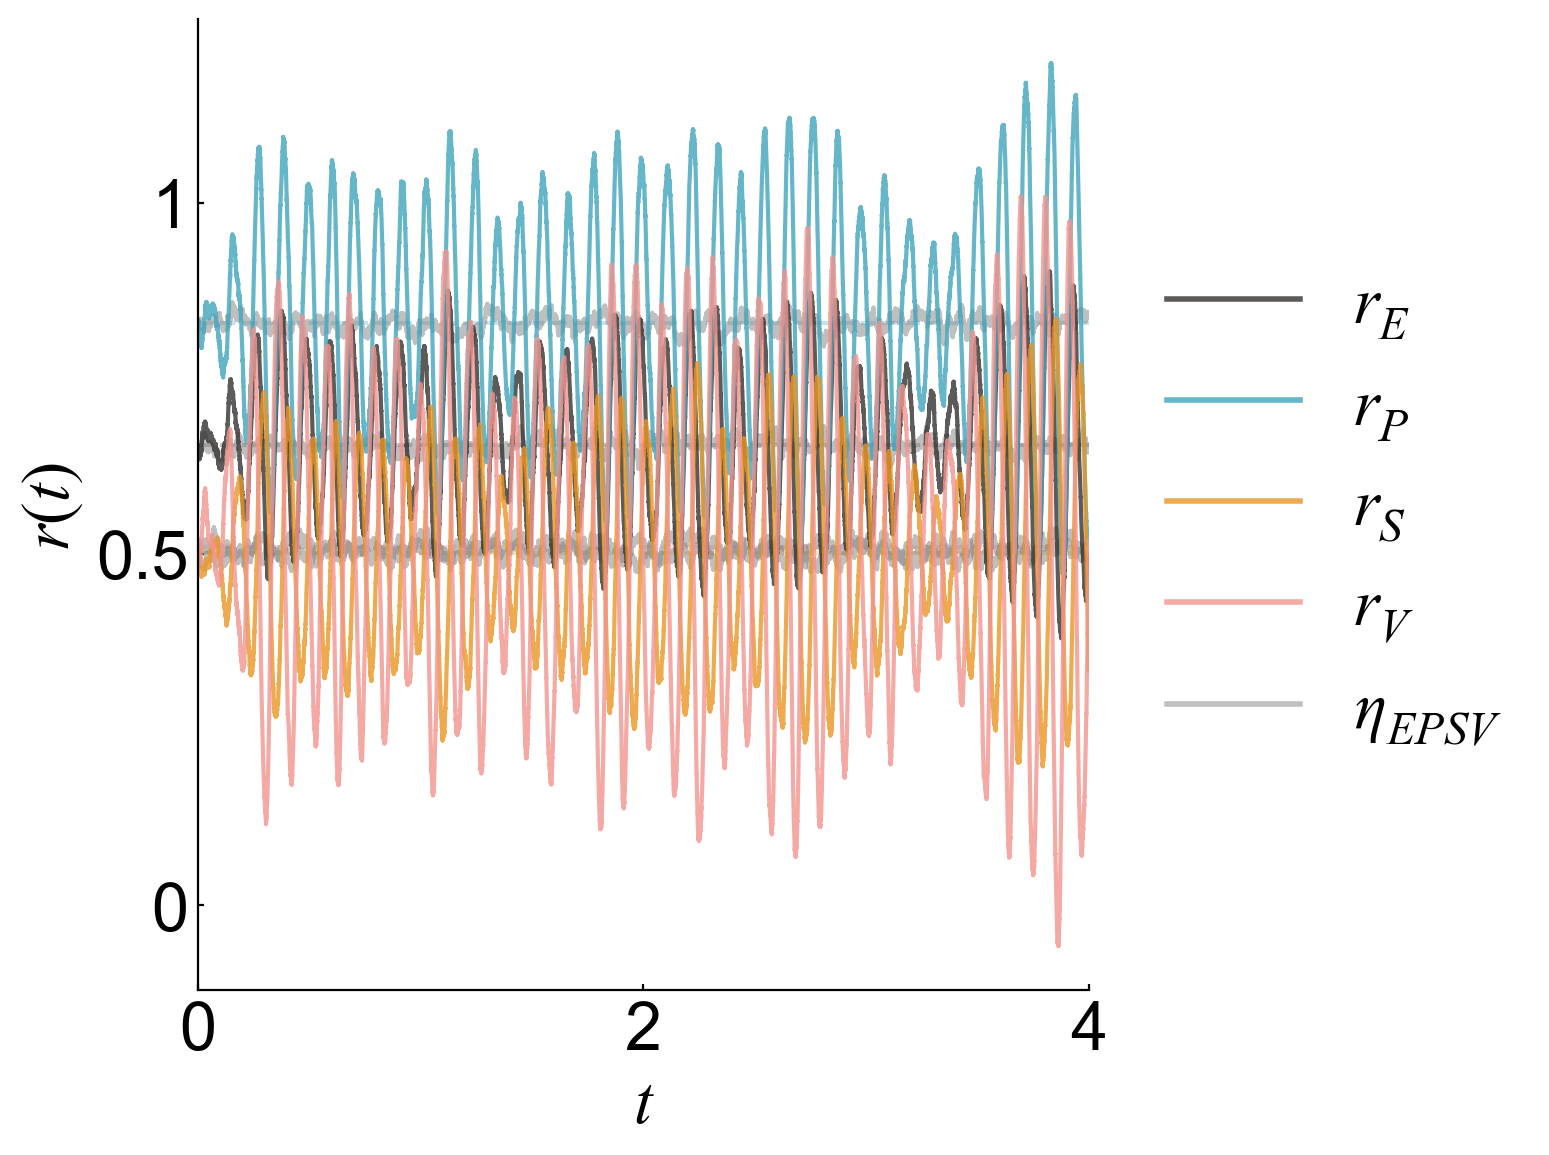

In [ ]:
# simulate linearised system with perturbation

T_sim = 4 # 50
variable = 'rate' # voltage or rate
noise_type = 'OU' # none, OU or white (voltage only)
h_ext = np.array([0.,0,0,0.1]) # stable
h0_tot = h0 + h_ext
h_tot = h1 * contrast + h0_tot

r_fp, _ = get_ss(r_fp, W, h1, h0_tot, contrast, z_lims=z_lims, N_z=N_z)
A, B, init_perturb = get_params(r_fp, W, TAU, tau_noise, sigma_noise, init_perturb_mag, dt, variable, noise_type)
x_trajectory, x_plot, _ = sim_local(r_fp, init_perturb, W, h_tot, A, B, variable, noise_type, T_sim=T_sim, dt=dt)
fig = plot_trajectory(x_plot, r_fp, W, h_ext, h_tot, variable, contrast, k, T_sim=T_sim, dt=dt, sim_type='local', noise_type=noise_type, savefig=False)


## correlations

### linearised system under white noise (voltage)

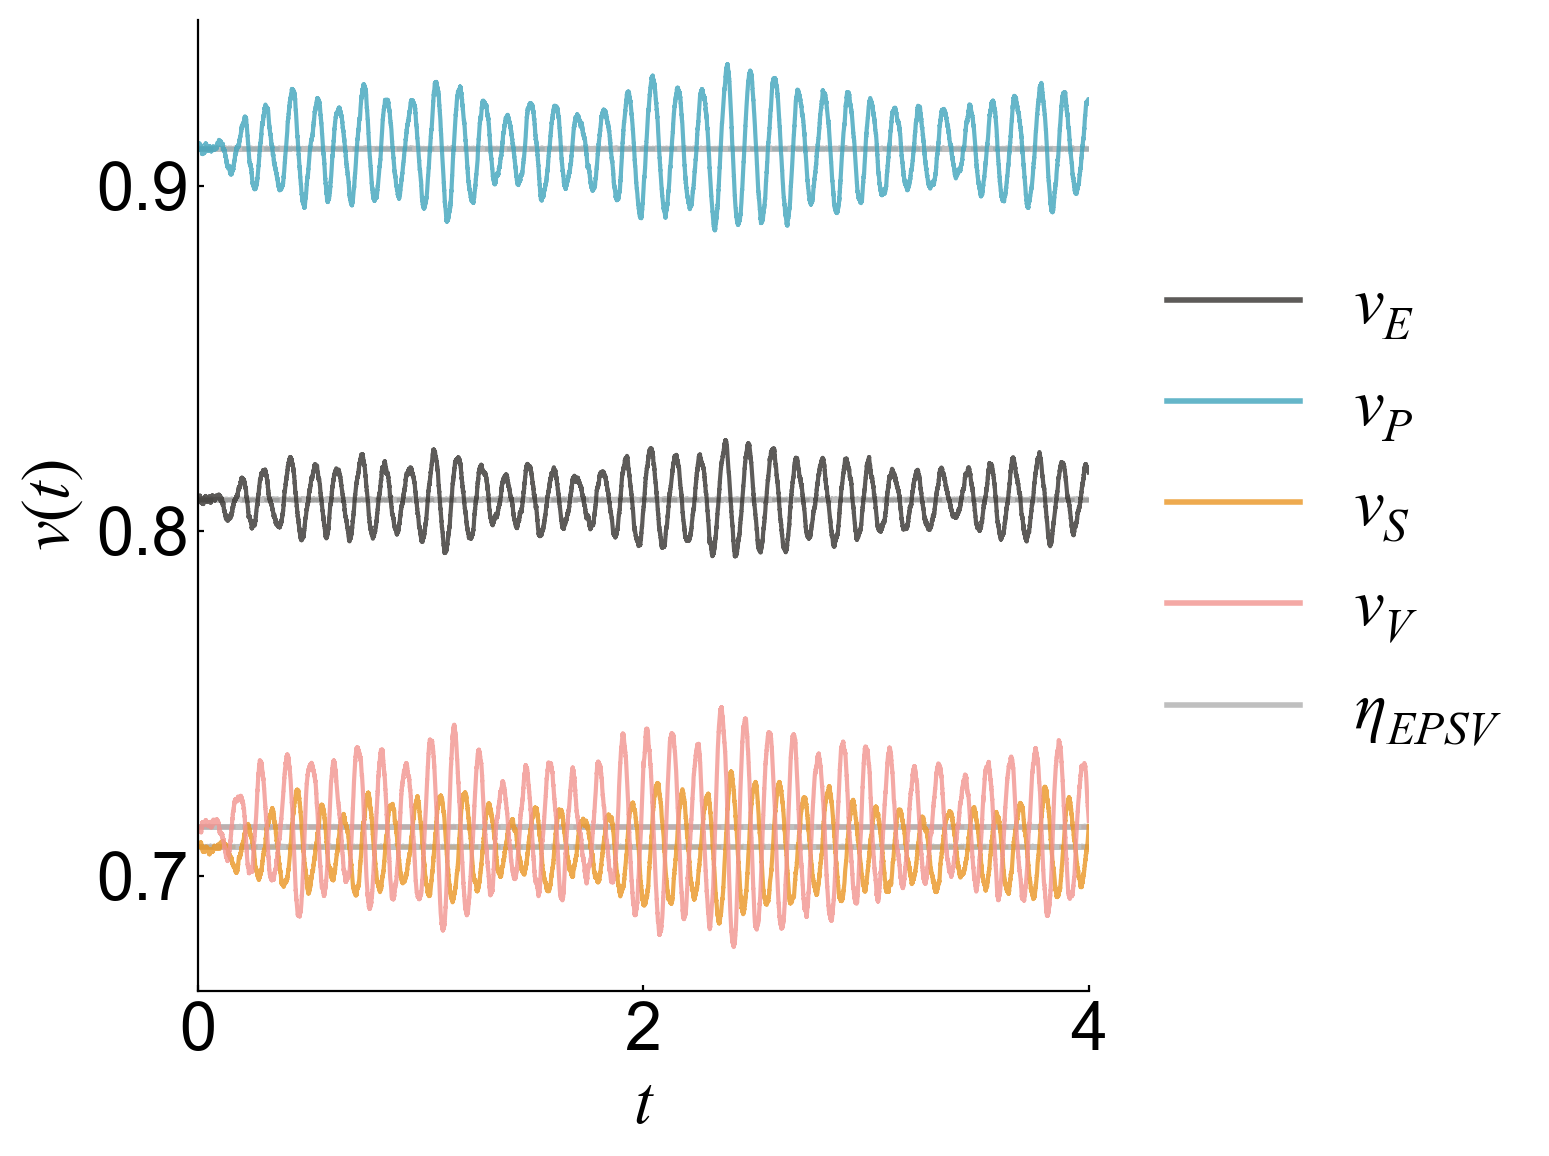

In [ ]:
# simulate linearised system with perturbation

T_sim = 4
variable = 'voltage'
noise_type = 'white'
h_ext = np.array([0,0,0,0.1])
h0_tot = h0 + h_ext
h_tot = h1 * contrast + h0_tot

r_fp, _ = get_ss(r_fp, W, h1, h0_tot, contrast, z_lims=z_lims, N_z=N_z)
A, B, init_perturb = get_params(r_fp, W, TAU, tau_noise, sigma_noise, init_perturb_mag, dt, variable, noise_type)
x_trajectory, x_plot, _ = sim_local(r_fp, init_perturb, W, h_tot, A, B, variable, noise_type, T_sim=T_sim, dt=dt)
fig = plot_trajectory(x_plot, r_fp, W, h_ext, h_tot, variable, contrast, k, T_sim=T_sim, dt=dt, sim_type='local', noise_type=noise_type, savefig=False)


/Users/lukej/Documents/Gatsby/code/scripts_new/simulation_functions.py:156: RuntimeWarning: Input "a" has an eigenvalue pair whose sum is very close to or exactly zero. The solution is obtained via perturbing the coefficients.
  return scipy.linalg.solve_continuous_lyapunov(A, Q) # note Q positive definite


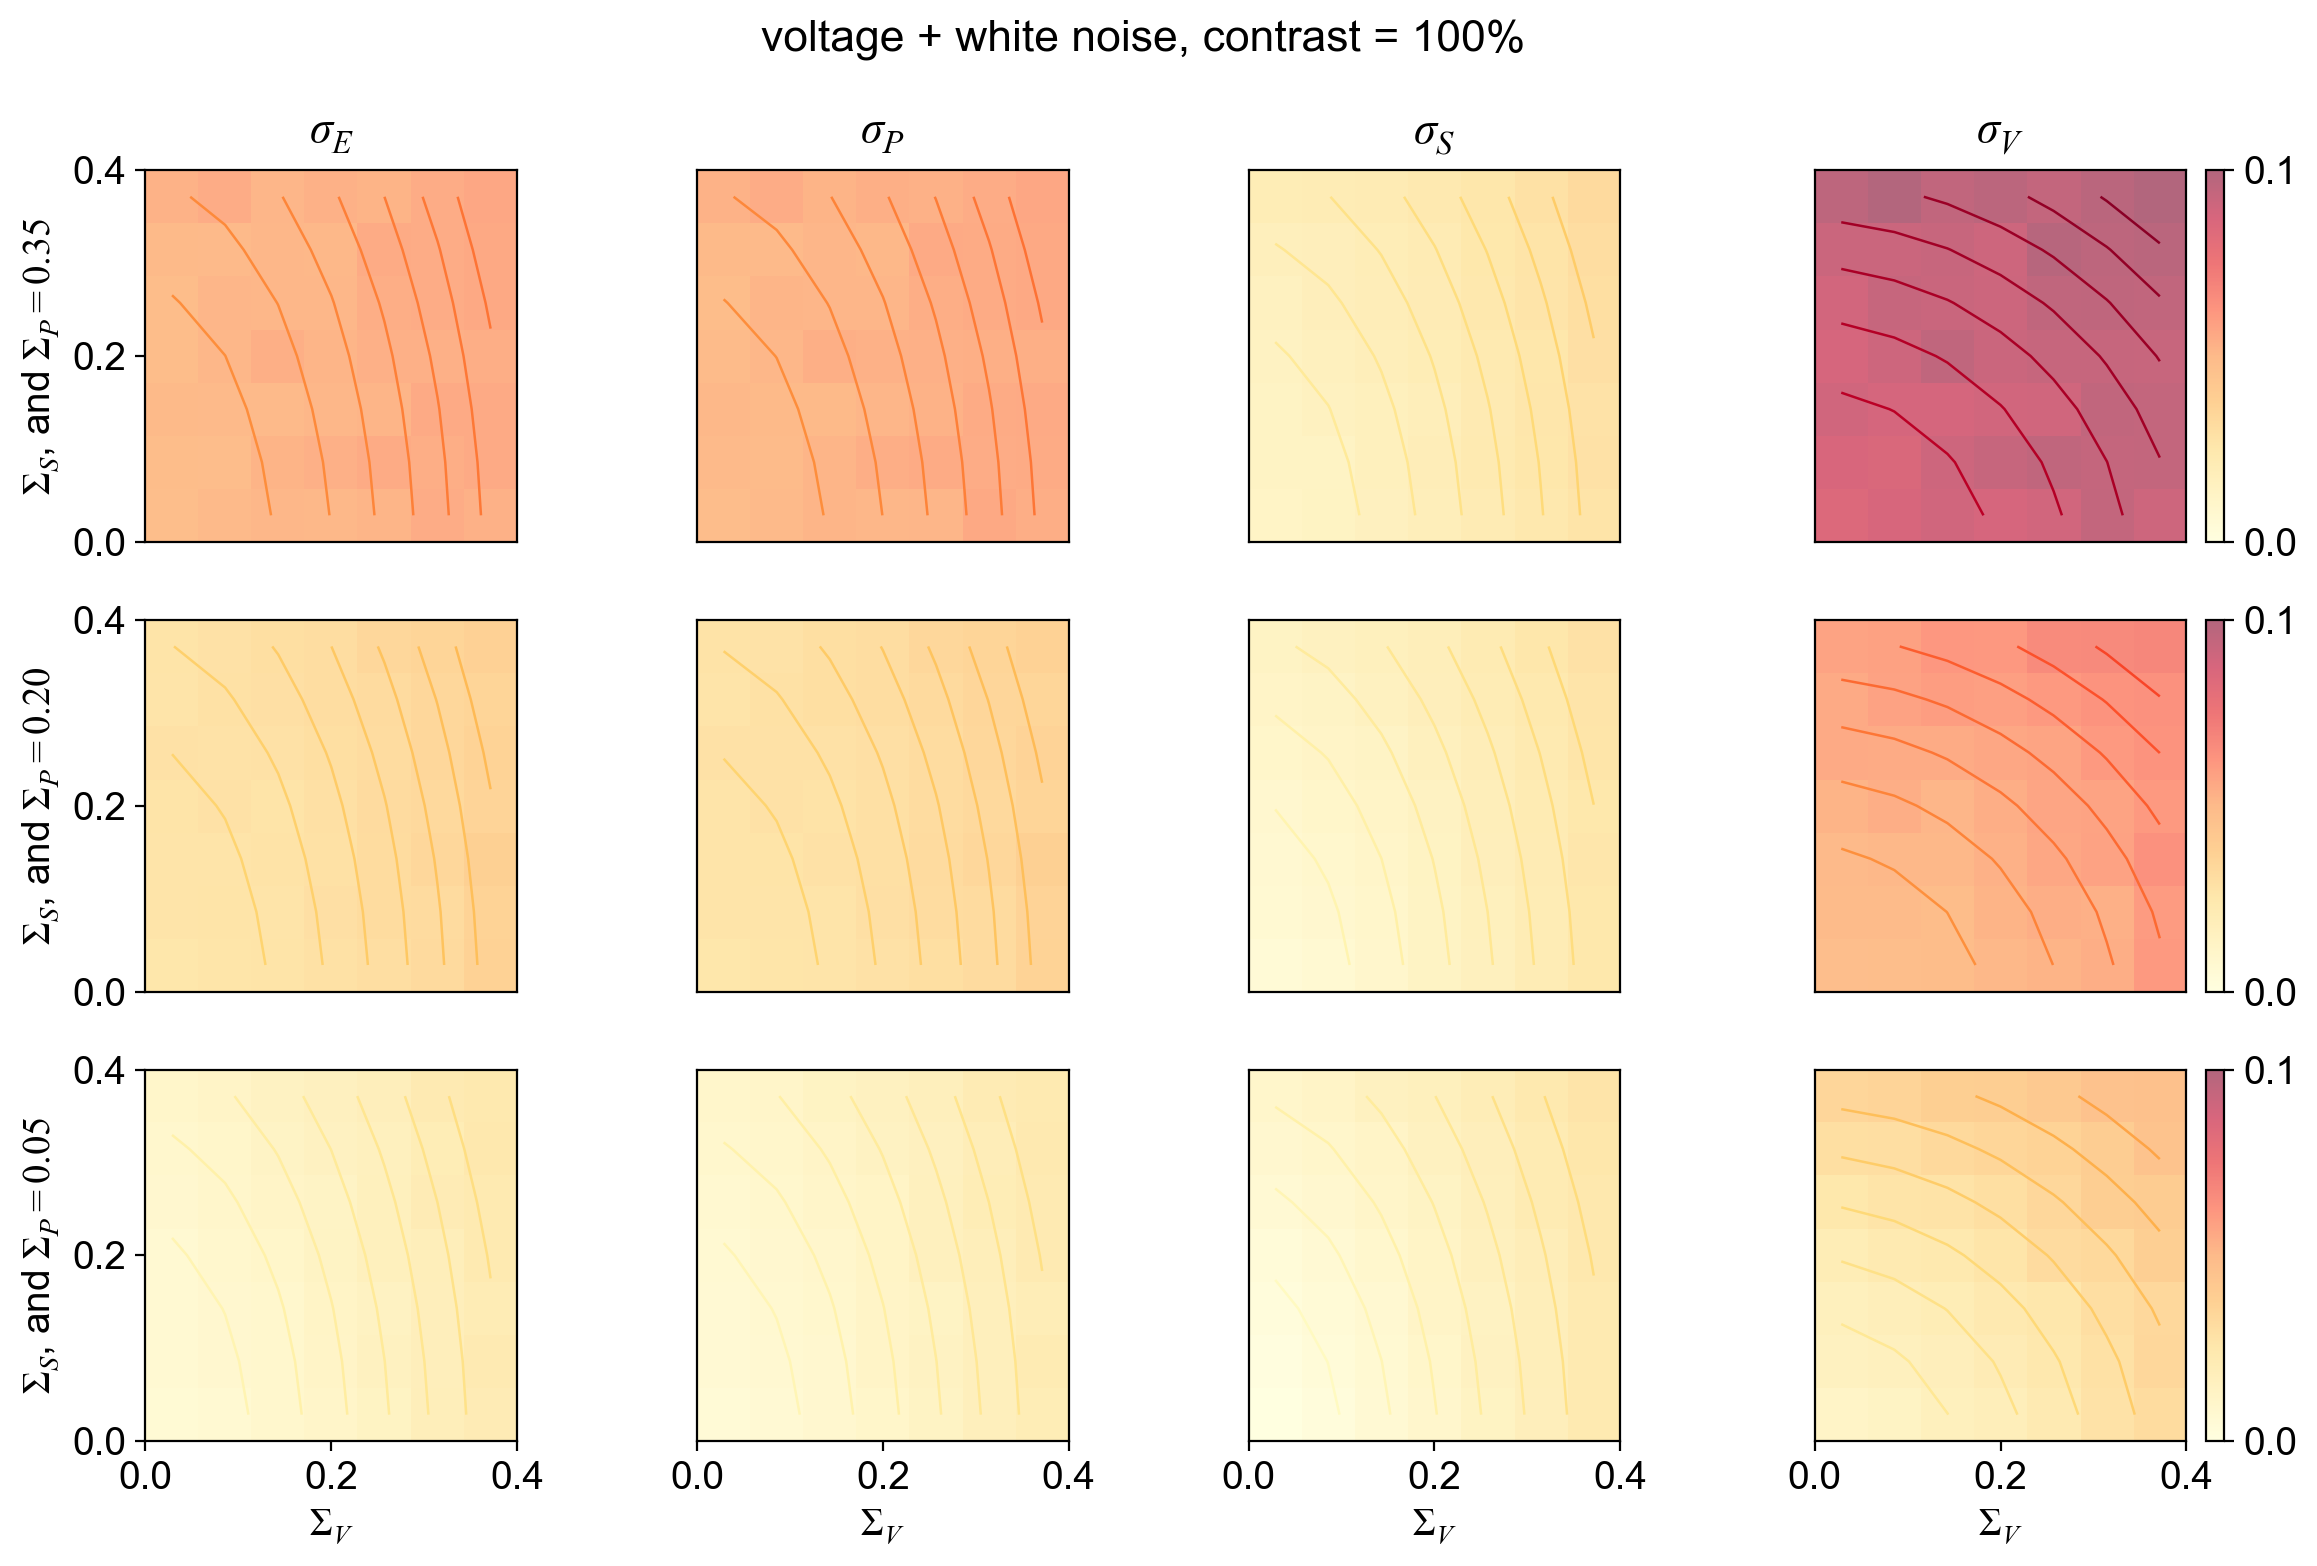

In [ ]:
# correlation matrix

T_sim = 4
variable = 'voltage'
noise_type = 'white'

init_perturb_mag = 0 # 1e-2
tau_noise = 2e-2 # (OU only) note 50ms 'slow noise' in Hennequin paper
noise_levels = np.array([0.05,0.2,0.35]) # for \sigma_PSV
sigma_E = 5e-2

fig = plot_variance_subplots(r_fp, init_perturb_mag, W, h_tot, dt, T_sim, TAU, tau_noise, noise_levels, sigma_E, variable, noise_type, contrast, savefig=False)


/Users/lukej/Documents/Gatsby/code/scripts_new/simulation_functions.py:156: RuntimeWarning: Input "a" has an eigenvalue pair whose sum is very close to or exactly zero. The solution is obtained via perturbing the coefficients.
  return scipy.linalg.solve_continuous_lyapunov(A, Q) # note Q positive definite


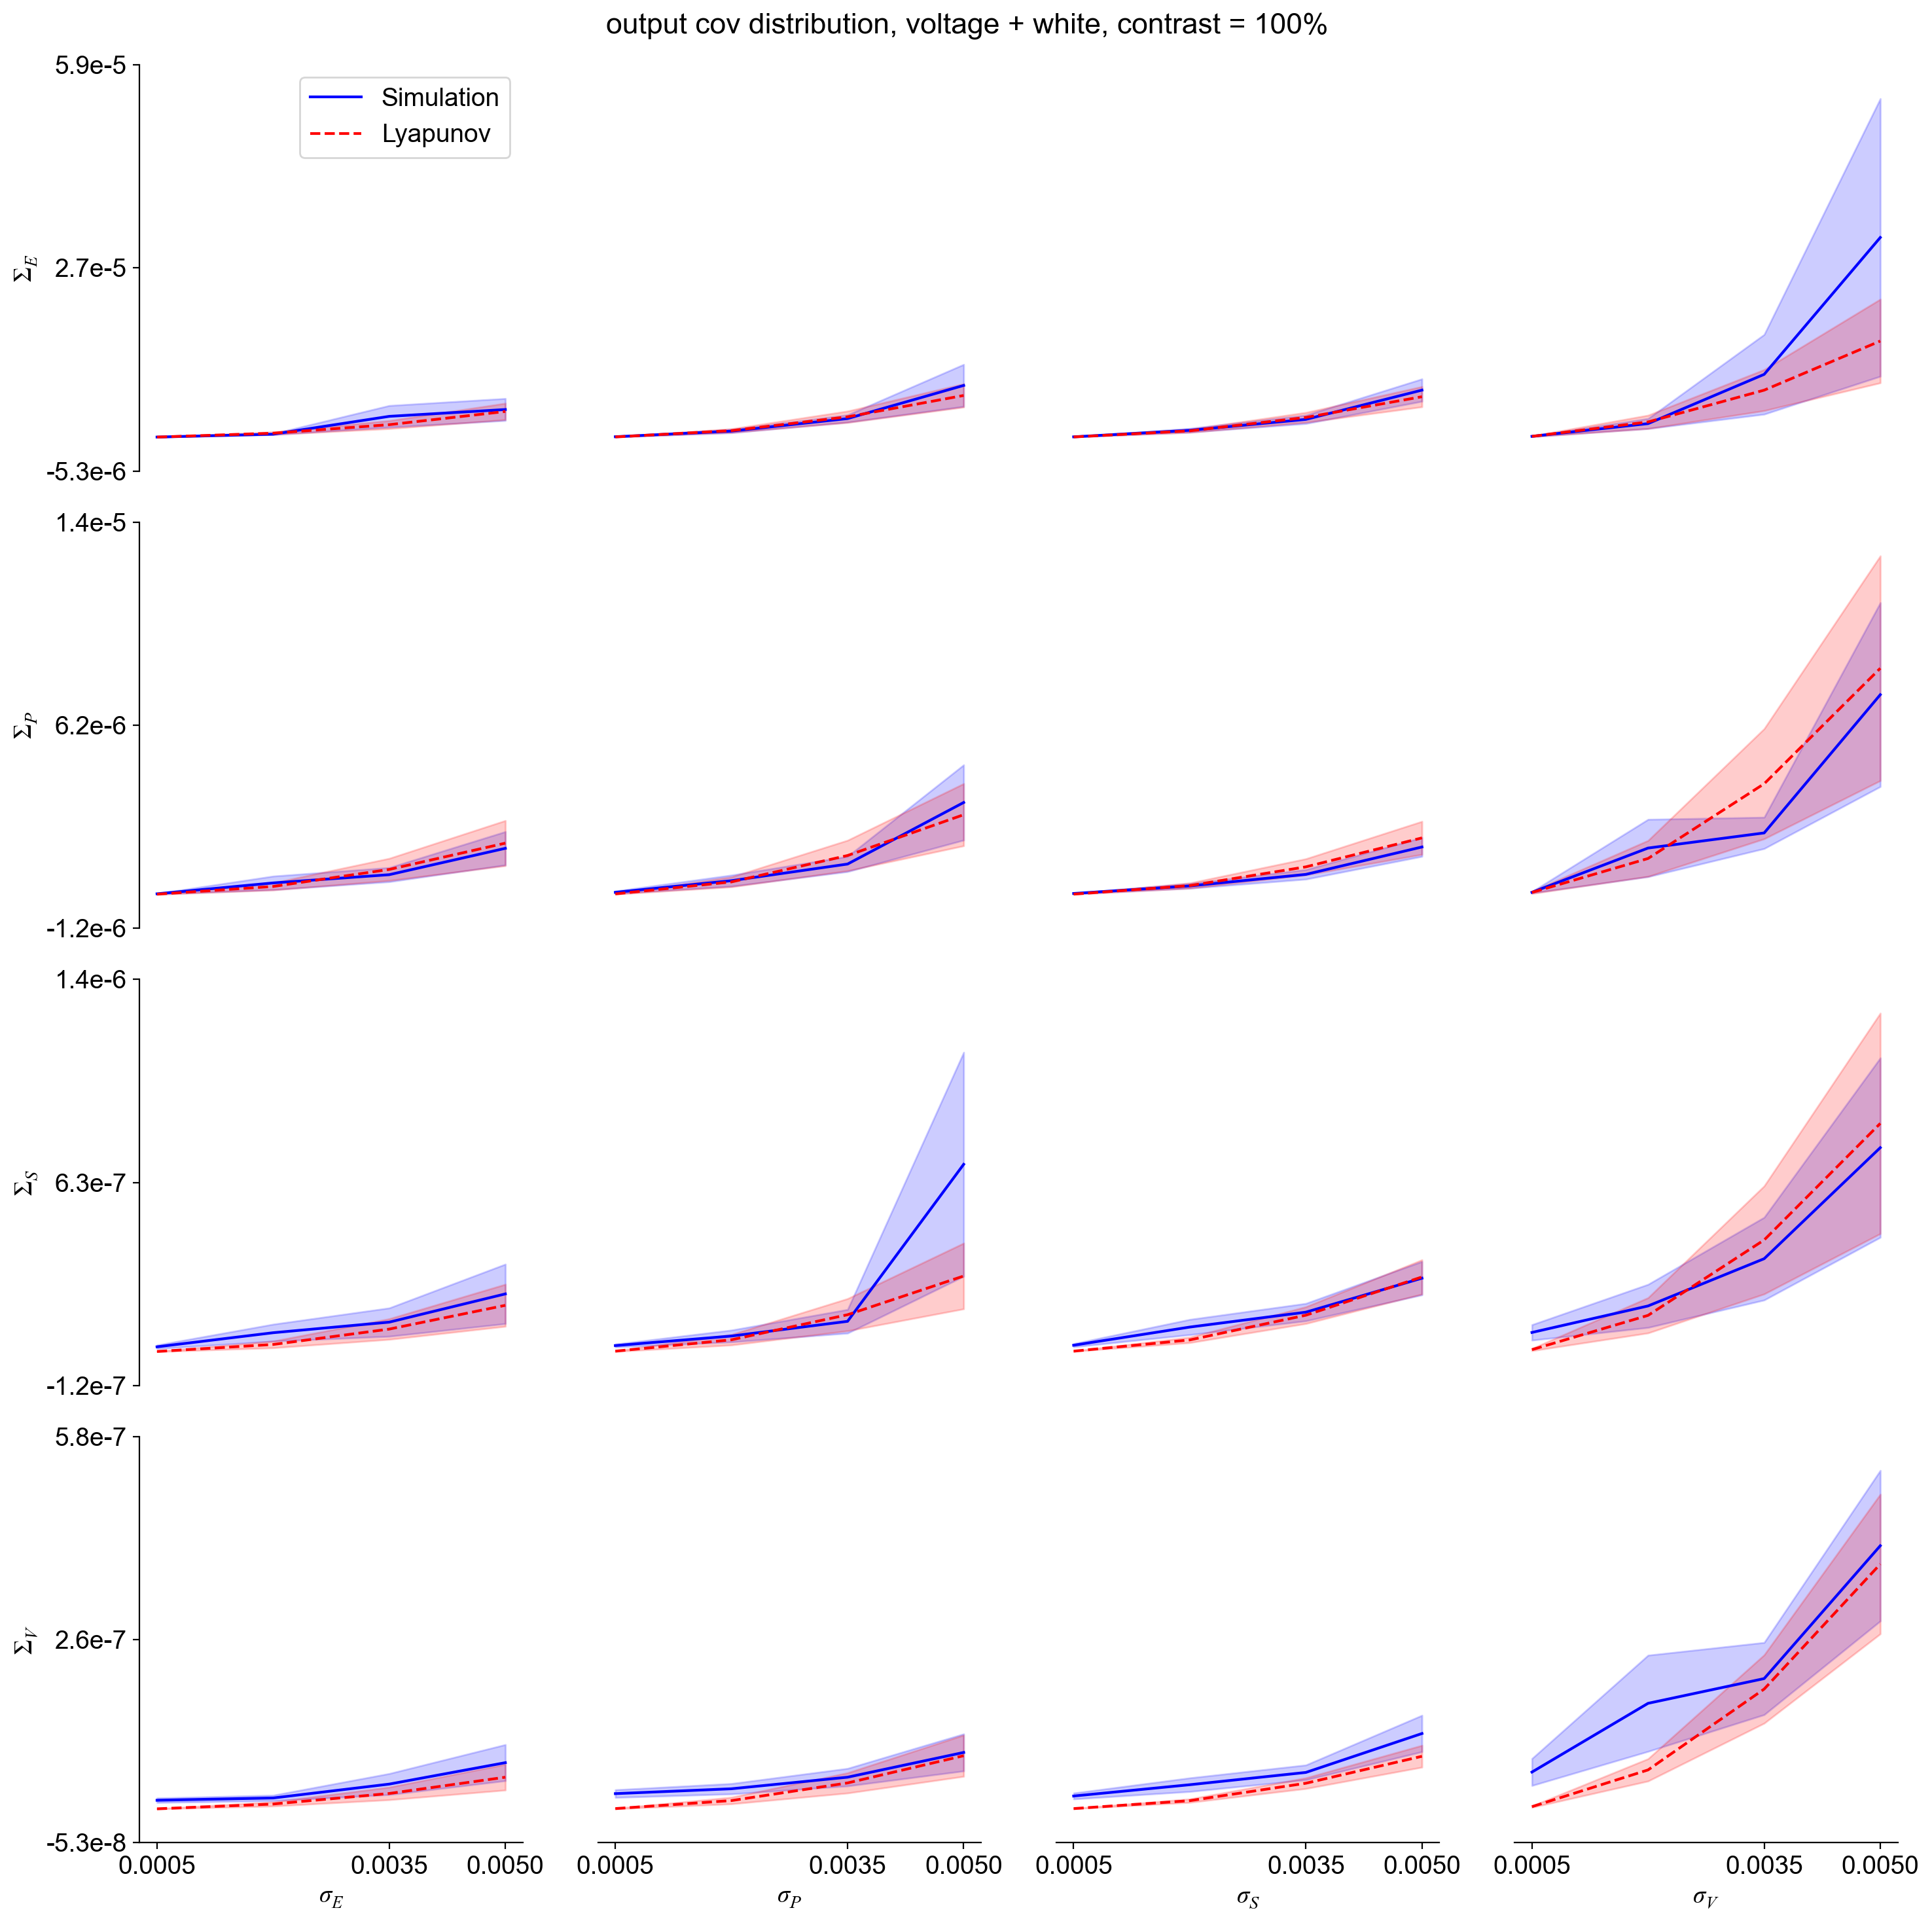

In [ ]:
# correlations across fits

top_k = 5 # number of fits
noise_lims = [0.0005, 0.005] # noise limits
n_levels = 4 # 5
T_sim = 5
variable = 'voltage'
noise_type = 'white'

params_list, r_fp_list = get_params_fits_list(top_params, top_fits, c_range, contrast=contrast, top_k=20)
variances_sim, variances_lyap = compute_cov_grid(params_list, r_fp_list, contrast, init_perturb_mag, TAU, tau_noise, sigma_noise, dt, T_sim, noise_lims, n_levels, variable, noise_type)
fig = plot_cov_grid(variances_sim, variances_lyap, noise_lims, n_levels, contrast, variable, noise_type, savefig=False)


### linearised system under coloured noise (voltage)

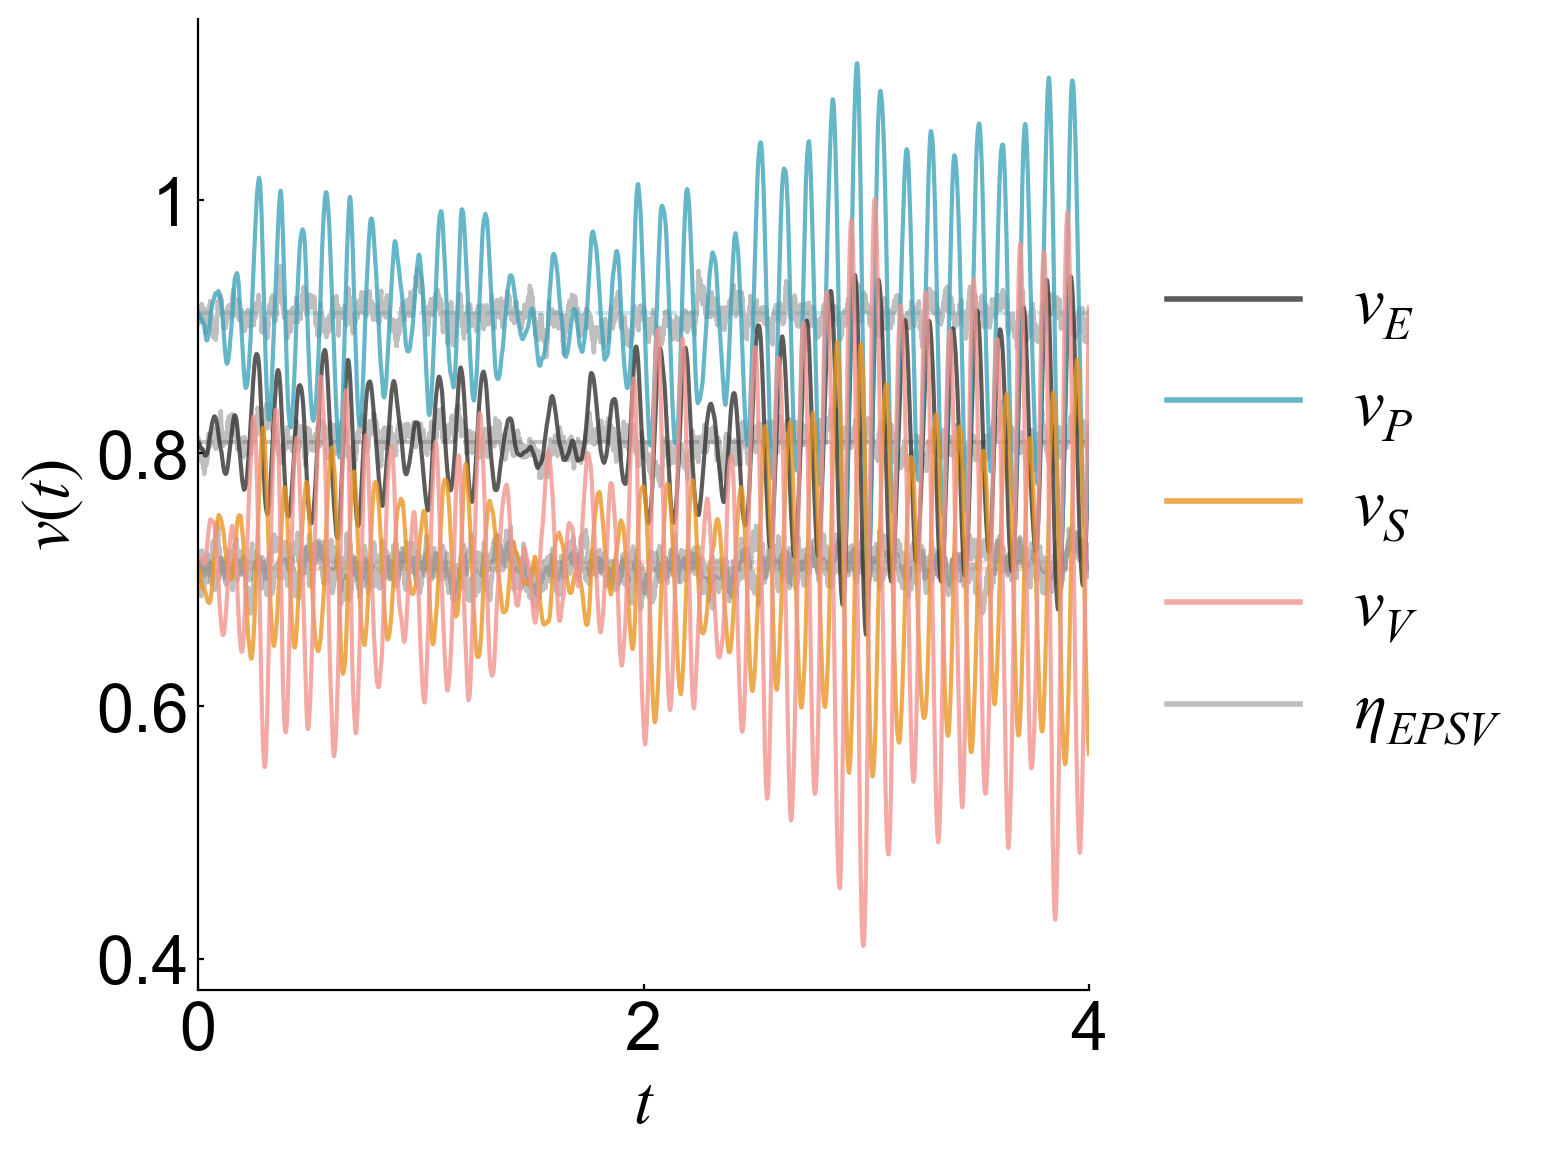

In [ ]:
# simulate linearised system with perturbation

T_sim = 4
variable = 'voltage'
noise_type = 'OU'
h_ext = np.array([0,0,0,0.1])
h0_tot = h0 + h_ext
h_tot = h1 * contrast + h0_tot

r_fp, _ = get_ss(r_fp, W, h1, h0_tot, contrast, z_lims=z_lims, N_z=N_z)
A, B, init_perturb = get_params(r_fp, W, TAU, tau_noise, sigma_noise, init_perturb_mag, dt, variable, noise_type)
x_trajectory, x_plot, _ = sim_local(r_fp, init_perturb, W, h_tot, A, B, variable, noise_type, T_sim=T_sim, dt=dt)
fig = plot_trajectory(x_plot, r_fp, W, h_ext, h_tot, variable, contrast, k, T_sim=T_sim, dt=dt, sim_type='local', noise_type=noise_type, savefig=False)


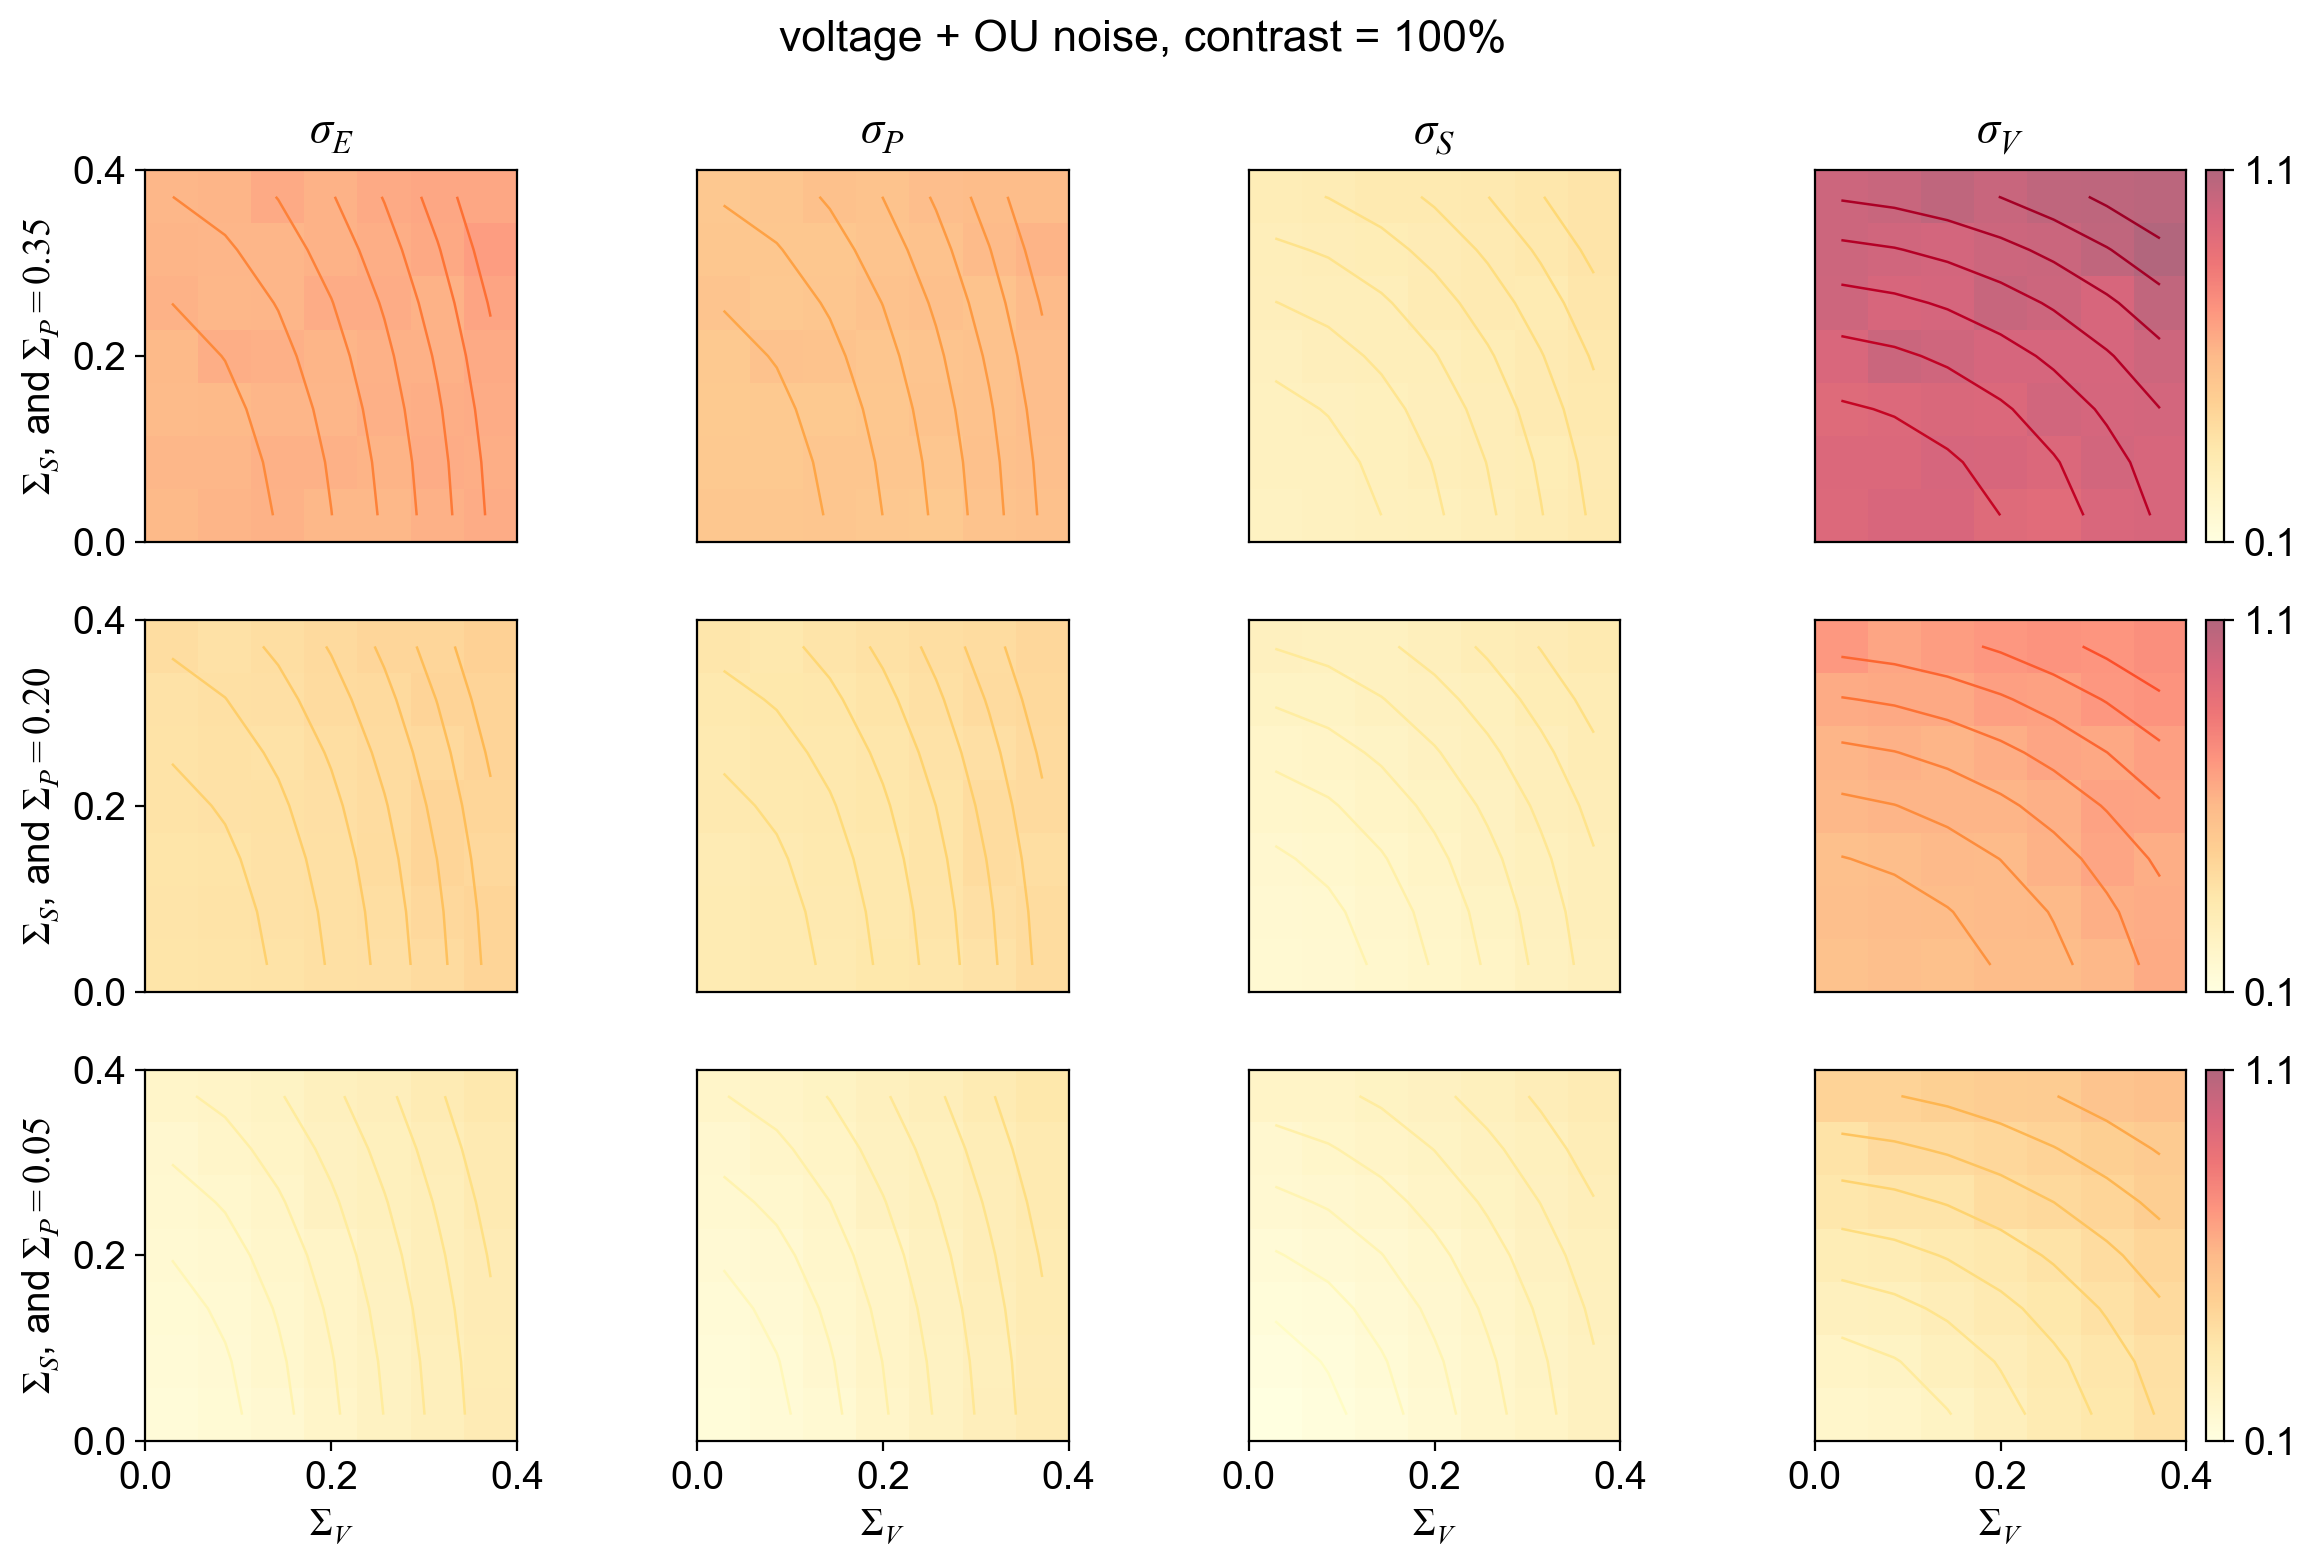

In [ ]:
# correlation matrix

T_sim = 40
variable = 'voltage'
noise_type = 'OU'
init_perturb_mag = 0 # 1e-2
noise_levels = [0.05,0.2,0.35]
sigma_E = 5e-2

fig = plot_variance_subplots(r_fp, init_perturb_mag, W, h_tot, dt, T_sim, TAU, tau_noise, noise_levels, sigma_E, variable, noise_type, contrast, savefig=False)


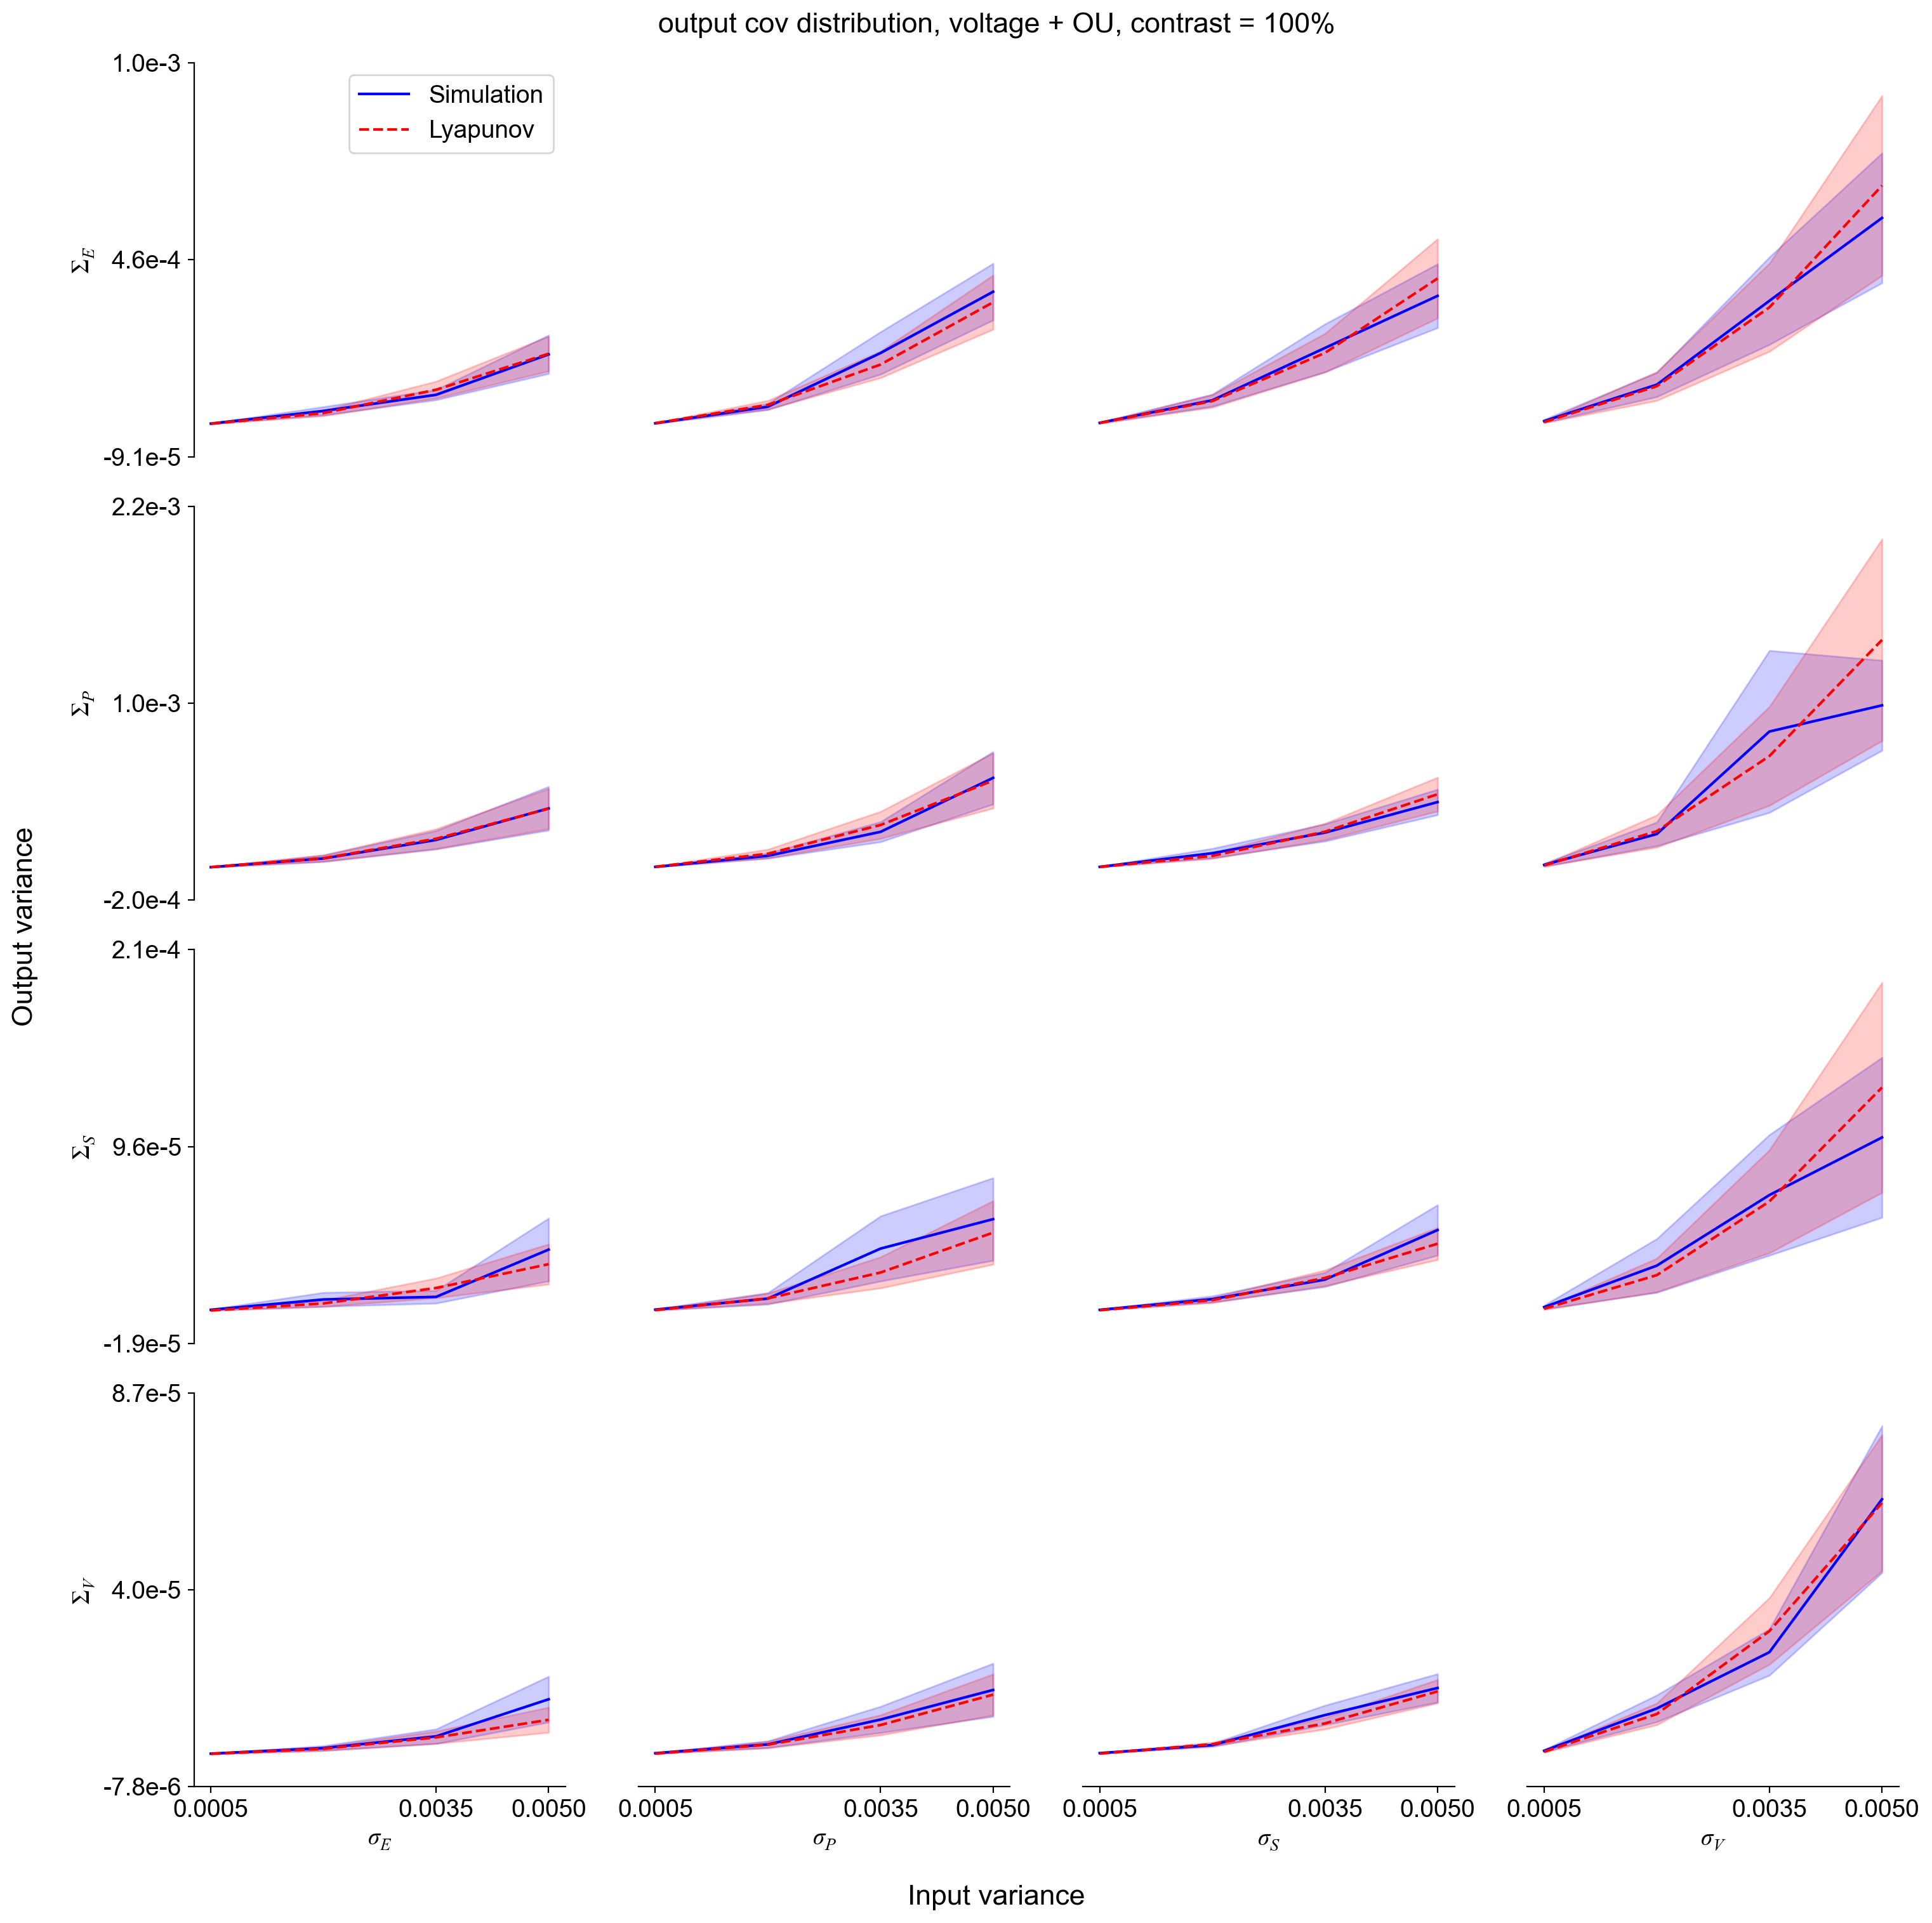

In [ ]:
# correlations across fits

top_k = 5
noise_lims = [0.0005, 0.005]
n_levels = 4 # 5
T_sim = 5
tau_noise = 2e-2
variable = 'voltage'
noise_type = 'OU'

params_list, r_fp_list = get_params_fits_list(top_params, top_fits, c_range, contrast=contrast, top_k=20)
variances_sim, variances_lyap = compute_cov_grid(params_list, r_fp_list, contrast, init_perturb_mag, TAU, tau_noise, sigma_noise, dt, T_sim, noise_lims, n_levels, variable, noise_type)
fig = plot_cov_grid(variances_sim, variances_lyap, noise_lims, n_levels, contrast, variable, noise_type, savefig=False)

### linearised system under coloured noise (rate)

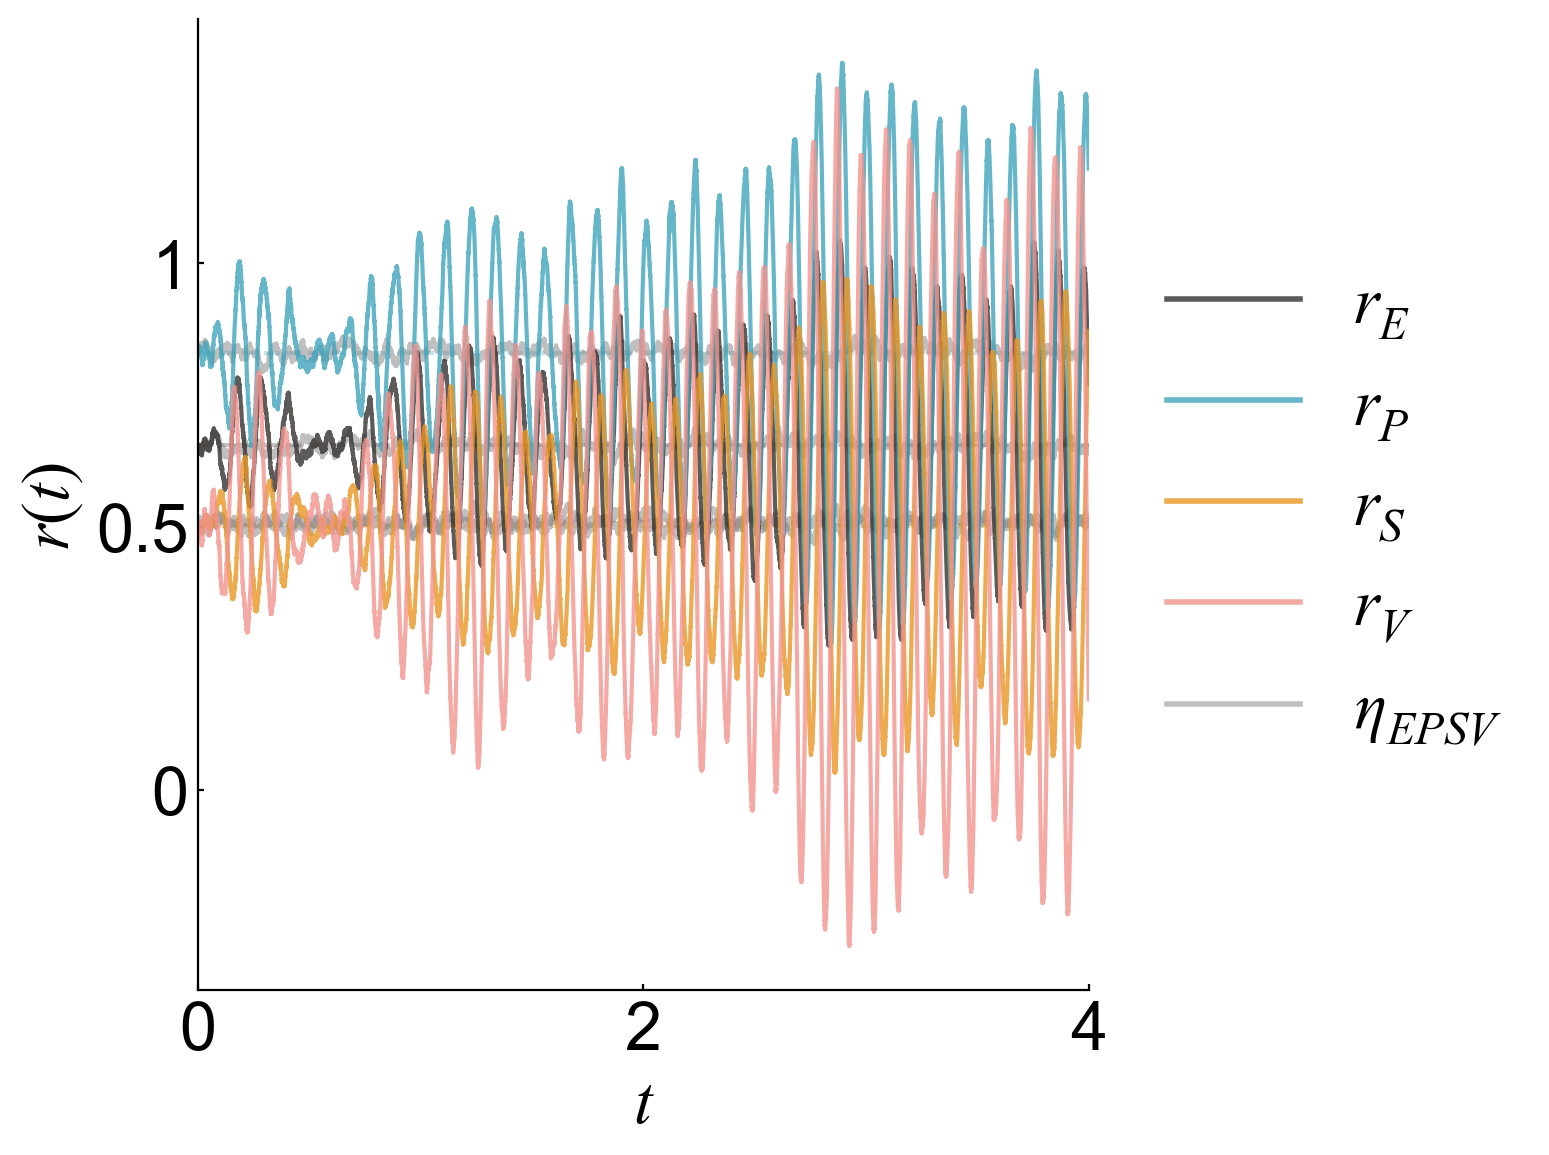

In [ ]:
# simulate linearised system with perturbation

T_sim = 4
variable = 'rate'
noise_type = 'OU'
init_perturb_mag = 0 # 1e-2
h_ext = np.array([0,0,0,0.1])
h_tot = h1 * contrast + h0_tot

r_fp, _ = get_ss(r_fp, W, h1, h0_tot, contrast, z_lims=z_lims, N_z=N_z)
A, B, init_perturb = get_params(r_fp, W, TAU, tau_noise, sigma_noise, init_perturb_mag, dt, variable, noise_type)
x_trajectory, x_plot, _ = sim_local(r_fp, init_perturb, W, h_tot, A, B, variable, noise_type, T_sim=T_sim, dt=dt)
fig = plot_trajectory(x_plot, r_fp, W, h_ext, h_tot, variable, contrast, k, T_sim=T_sim, dt=dt, sim_type='local', noise_type=noise_type, savefig=False)


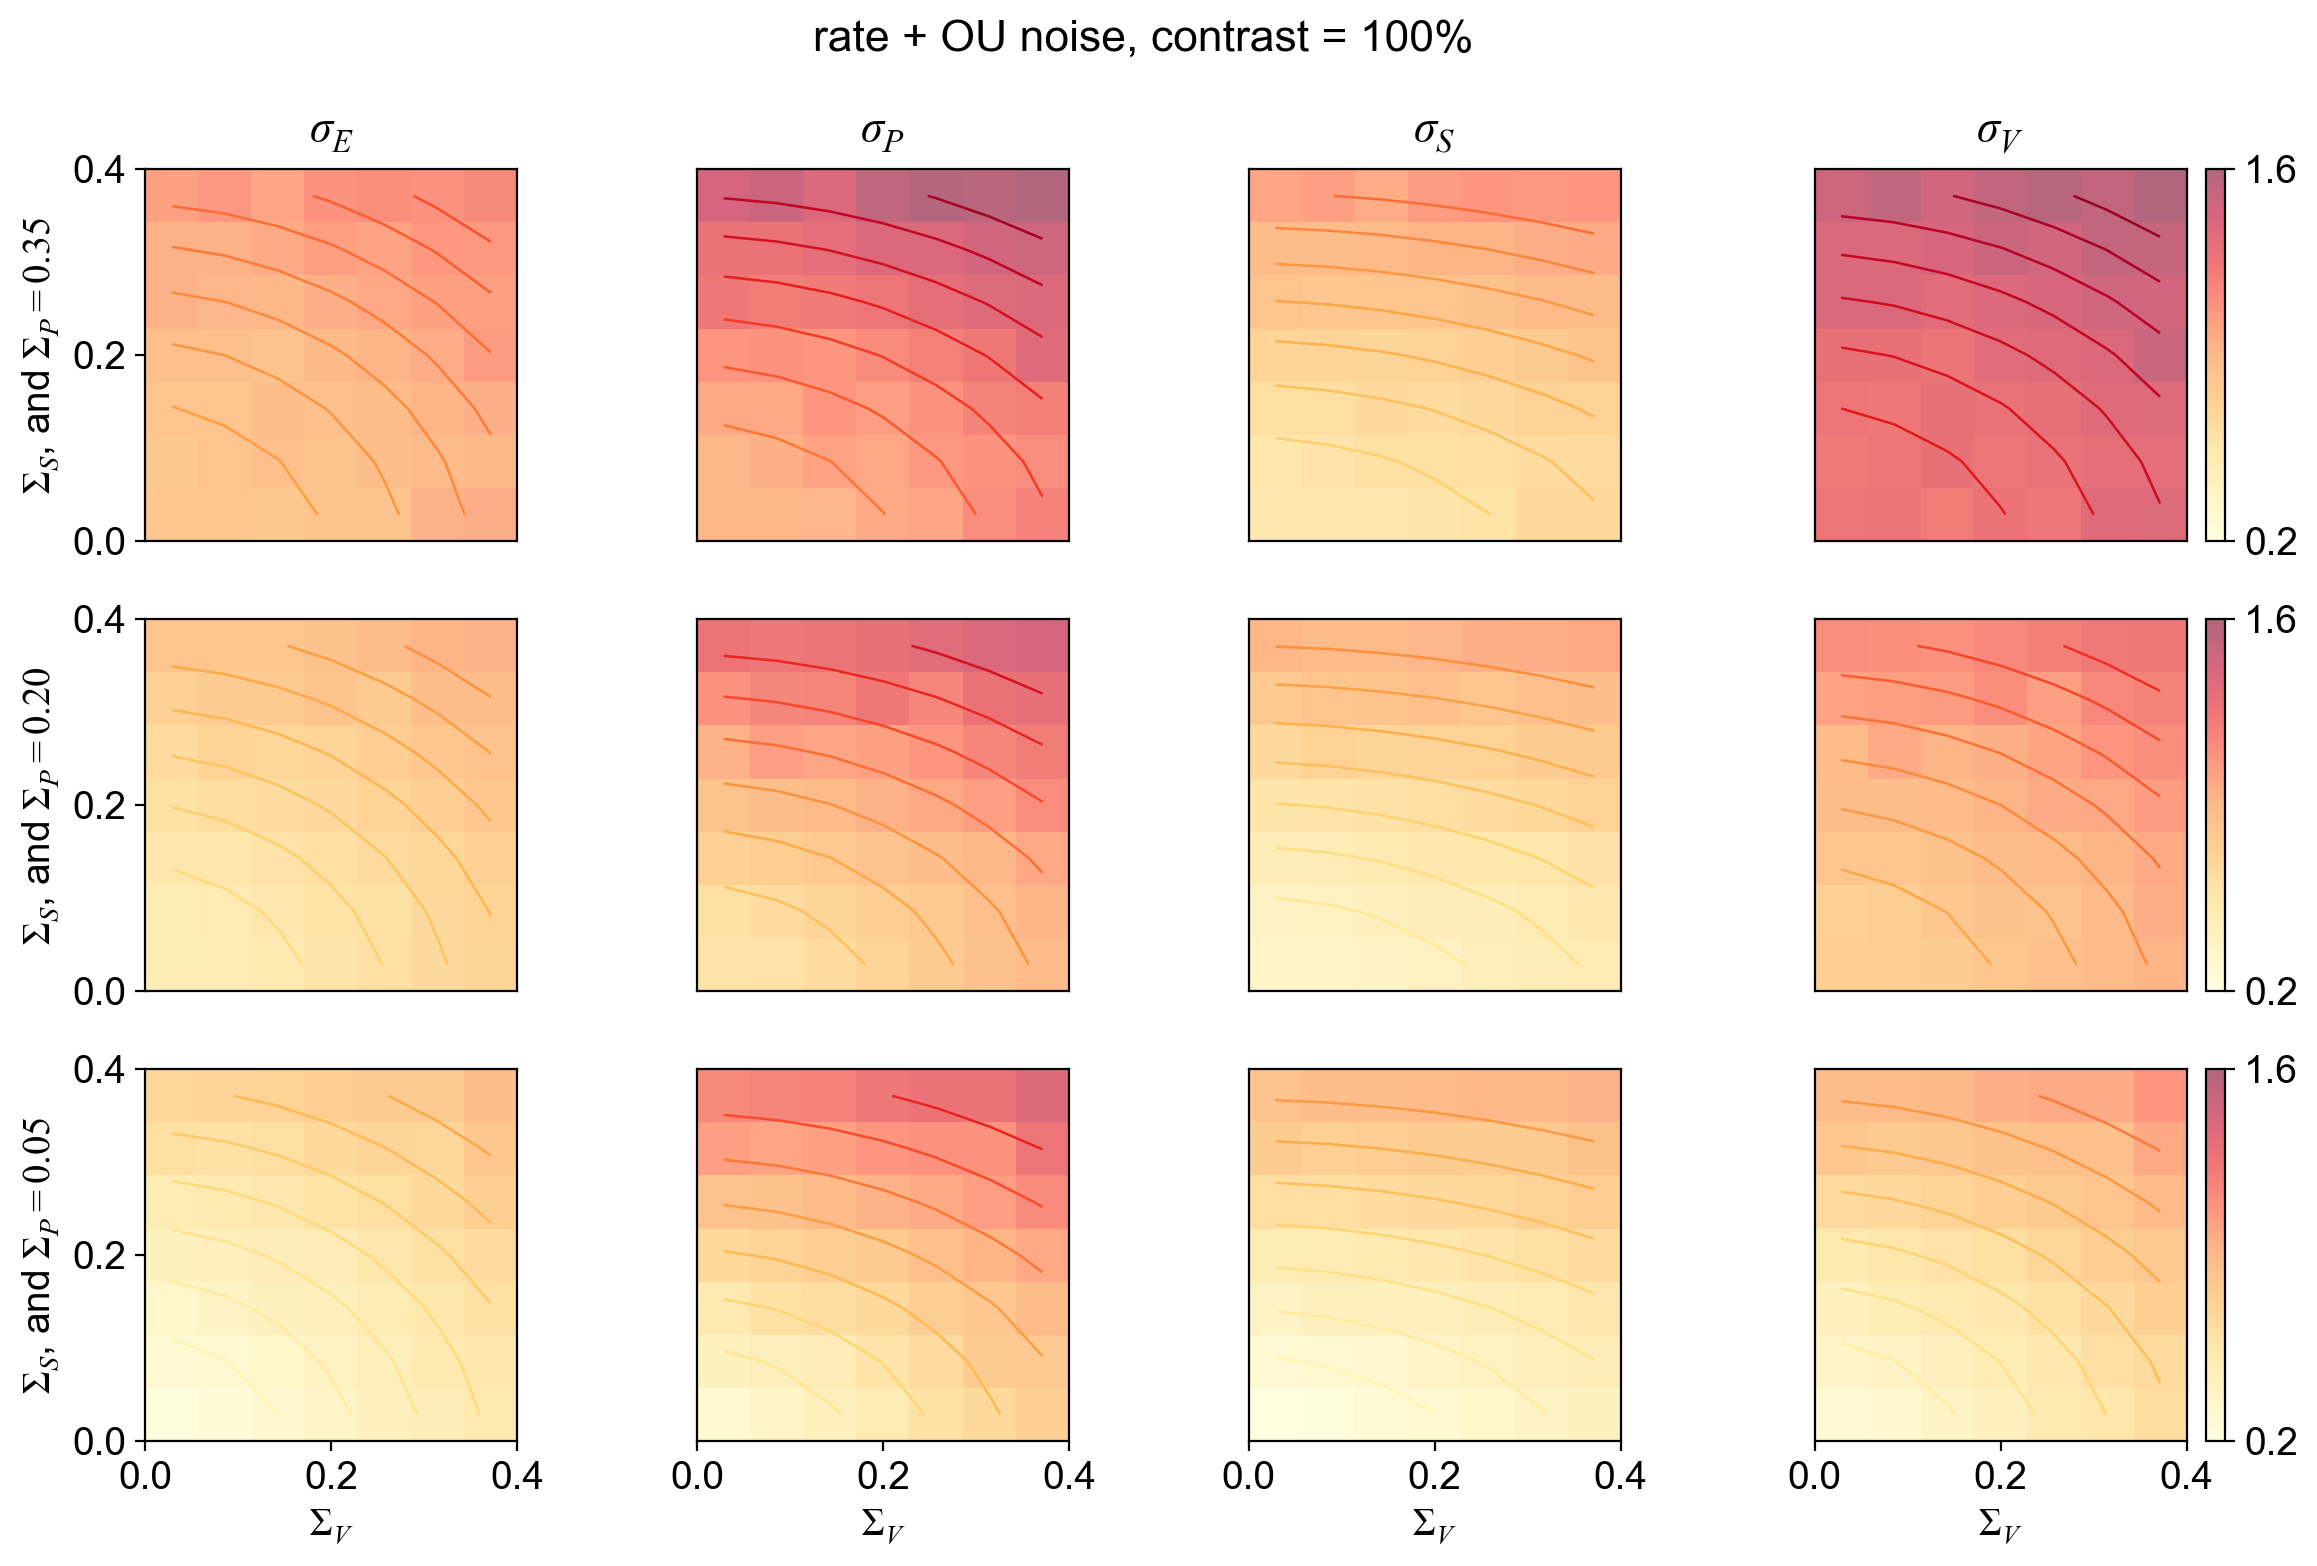

In [ ]:
# correlation matrix

T_sim = 40
variable = 'rate'
noise_type = 'OU'
init_perturb_mag = 0 # 1e-2
noise_levels = [0.05,0.2,0.35]
sigma_E = 5e-2

fig = plot_variance_subplots(r_fp, init_perturb_mag, W, h_tot, dt, T_sim, TAU, tau_noise, noise_levels, sigma_E, variable, noise_type, contrast, savefig=False)


In [ ]:
# correlations across fits

top_k = 5
noise_lims = [0.0005, 0.005]
n_levels = 4 # 5
T_sim = 5
variable = 'rate'
noise_type = 'OU'

params_list, r_fp_list = get_params_fits_list(top_params, top_fits, c_range, contrast=contrast, top_k=20)
variances_sim, variances_lyap = compute_cov_grid(params_list, r_fp_list, contrast, init_perturb_mag, TAU, tau_noise, sigma_noise, dt, T_sim, noise_lims, n_levels, variable, noise_type)
fig = plot_cov_grid(variances_sim, variances_lyap, noise_lims, n_levels, contrast, variable, noise_type, savefig=False)


### covariance estimation error

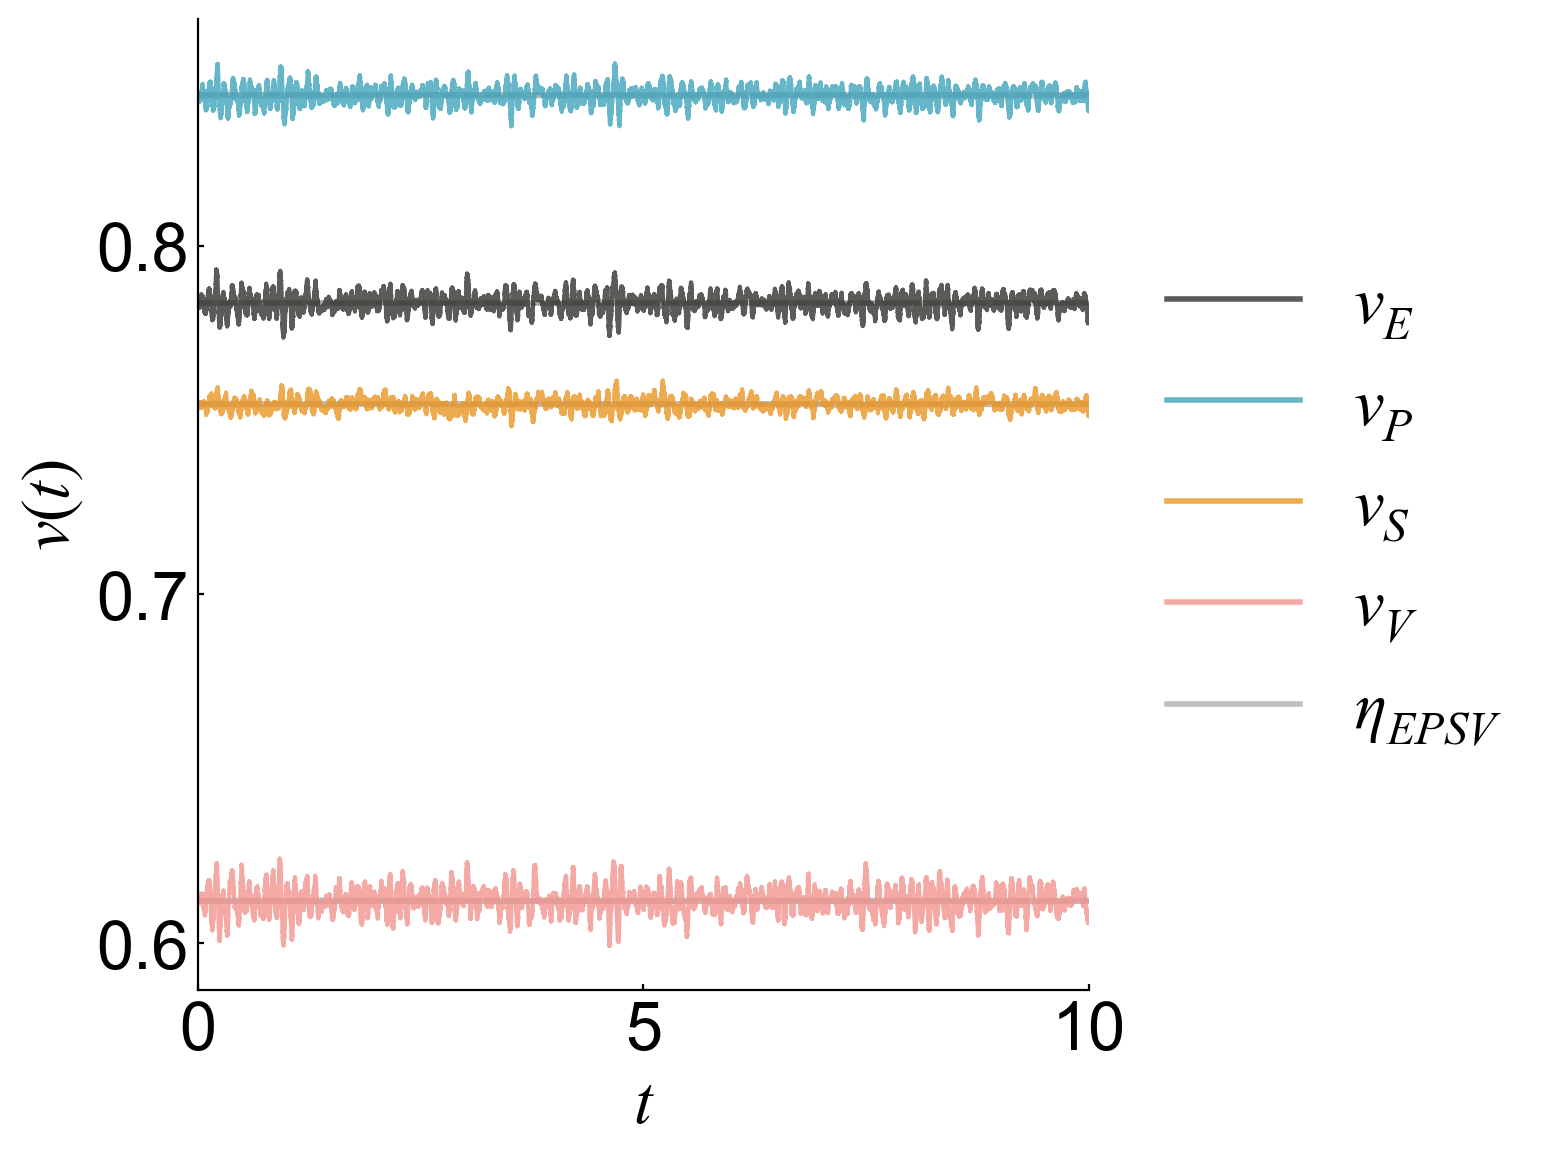

In [ ]:
# simulate linearised system with perturbation

T_sim = 10
variable = 'voltage'
noise_type = 'white'
init_perturb_mag = 0
h_ext = np.array([0,0,0,0.1]) 
h0_tot = h0 + h_ext
h_tot = h1 * contrast + h0_tot

r_fp, _ = get_ss(r_fp, W, h1, h0_tot, contrast, z_lims=z_lims, N_z=N_z)
A, B, init_perturb = get_params(r_fp, W, TAU, tau_noise, sigma_noise, init_perturb_mag, dt, variable, noise_type)
x_trajectory, x_plot, _ = sim_local(r_fp, init_perturb, W, h_tot, A, B, variable, noise_type, T_sim=T_sim, dt=dt)
fig = plot_trajectory(x_plot, r_fp, W, h_ext, h_tot, variable, contrast, k, T_sim=T_sim, dt=dt, sim_type='local', noise_type=noise_type, savefig=False)


/Users/lukej/Documents/Gatsby/code/scripts_new/simulation_functions.py:156: RuntimeWarning: Input "a" has an eigenvalue pair whose sum is very close to or exactly zero. The solution is obtained via perturbing the coefficients.
  return scipy.linalg.solve_continuous_lyapunov(A, Q) # note Q positive definite


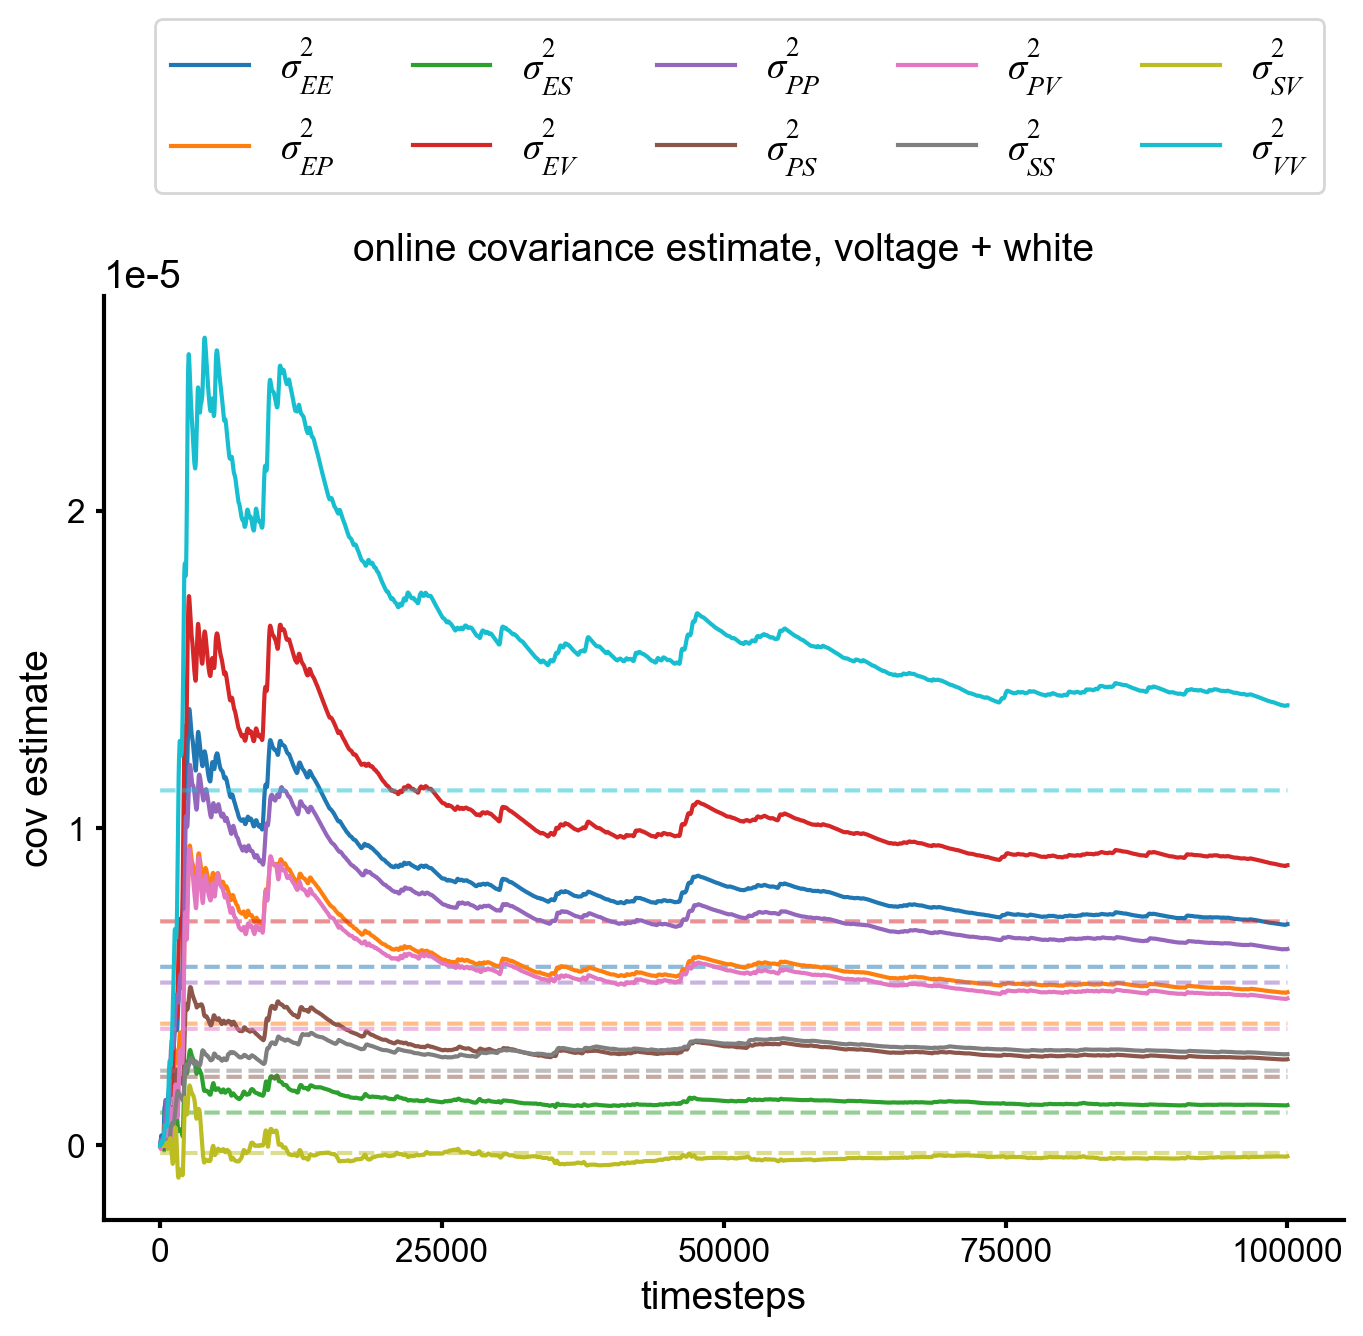

In [18]:
# online cov estimation (use to determine how long to sim)

online_covs, lyapunov_cov, cov_errors = estimate_online_covariance(x_trajectory, W, A, B, variable)
fig = plot_unique_correlations(online_covs, lyapunov_cov, variable, noise_type, normalised=False, savefig=False)


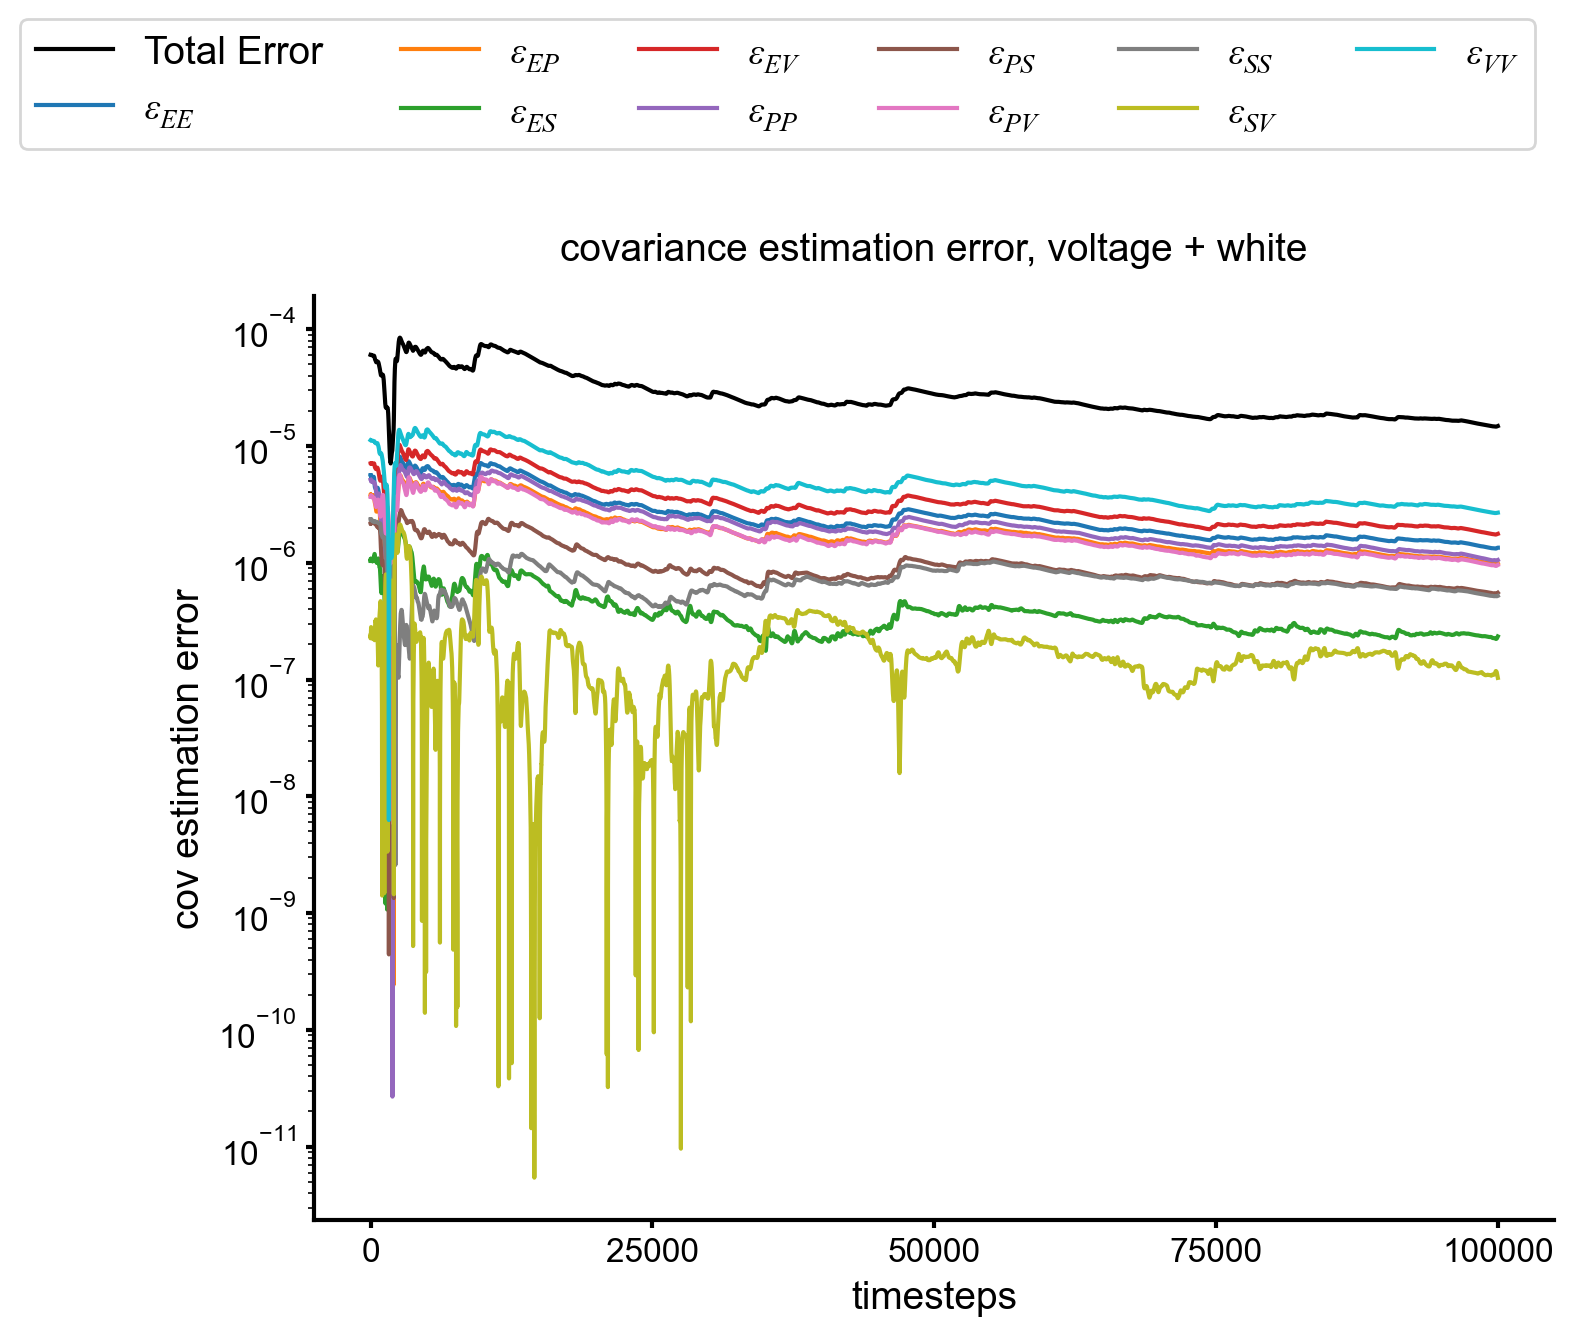

In [19]:
fig = plot_covariance_errors(online_covs, cov_errors, variable, noise_type, savefig=False)

### phase space simulations

point 0: [0.6526785  0.75937107 0.6461231  0.35616169] is a stable fixed point


/Users/lukej/Documents/Gatsby/code/scripts_new/simulation_functions.py:494: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


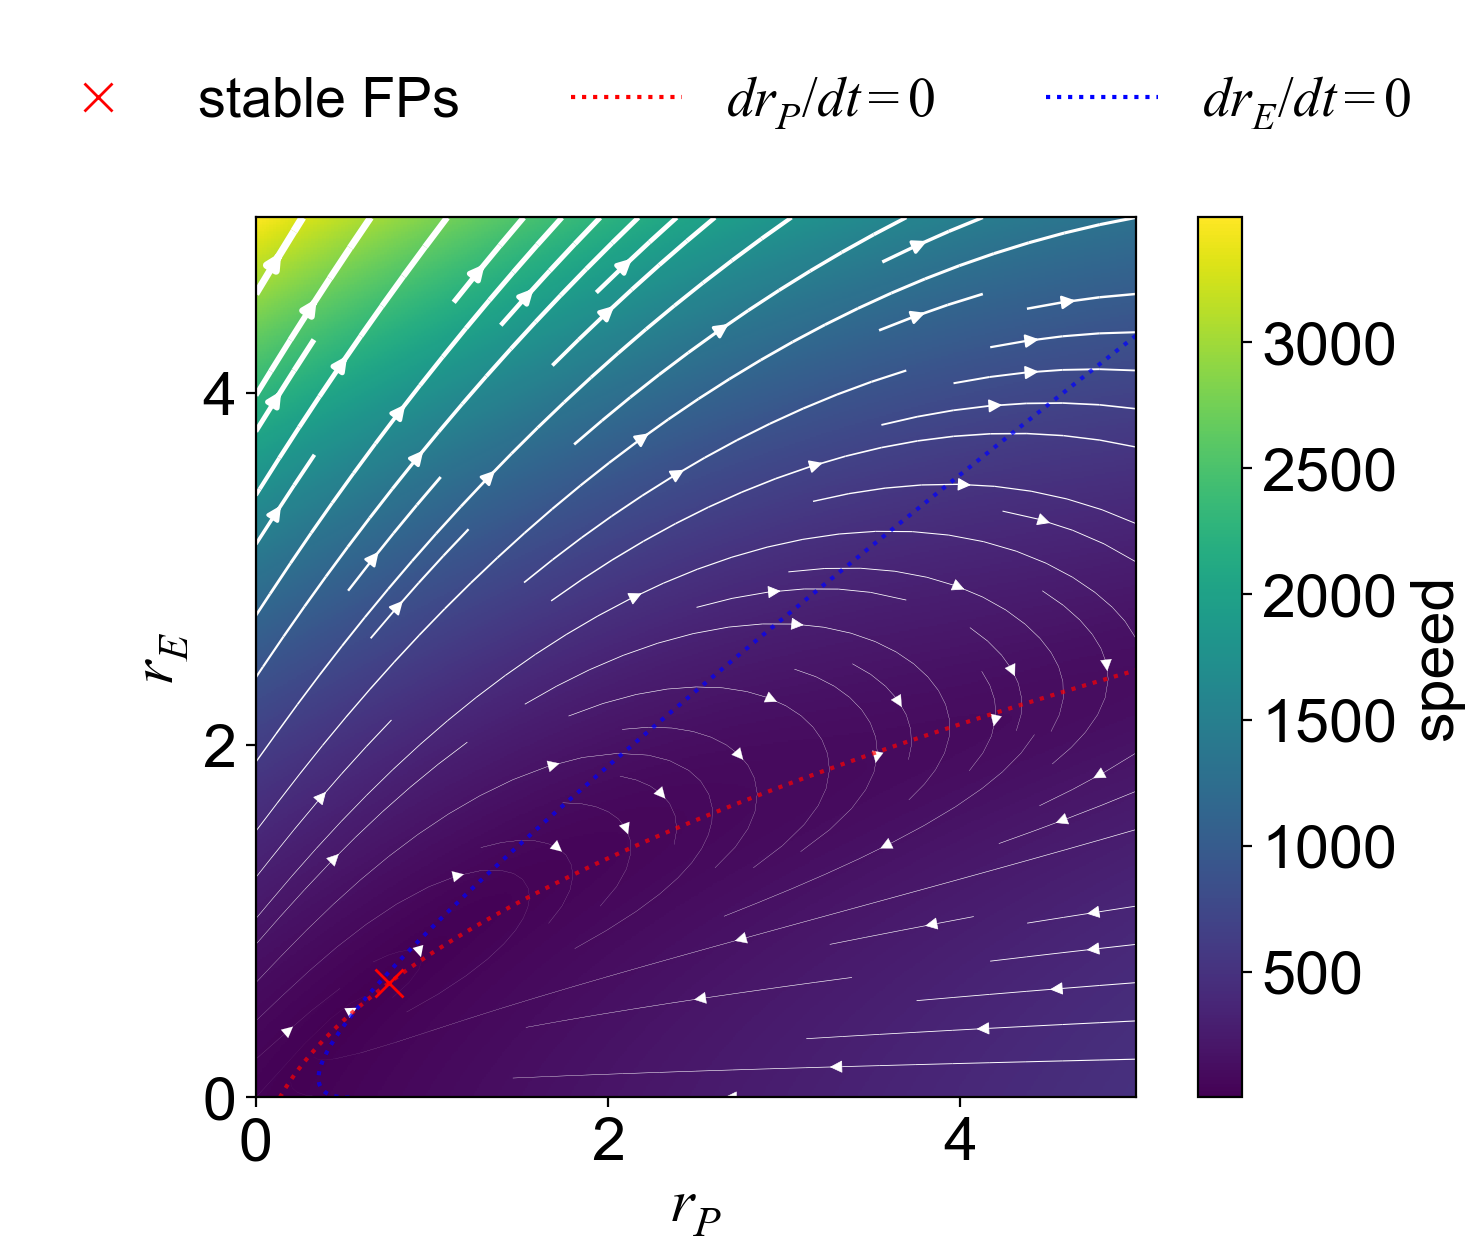

In [ ]:
# phase plane for single fit/contrast

k = 3
contrast = 1
W, h1, h0 = top_params[k]
h_ext = np.array([0, 0, 0, 2])
h0_tot = h0 + h_ext
h_tot = h1 * contrast + h0_tot
x_pop= 'P'
y_pop = 'E'
x_lims = (0, 5)
y_lims = (0, 5)

_, r_fp_list, *_ = get_fit_poly_1(W, h1, h0_tot, contrast, c_range, means, N_z=1000000) # r_fp_list_refined = [lambda]
fig, ax = plot_single_phase_plane(W, h1, h0, h_ext, contrast, TAU, x_pop, y_pop, x_lims, y_lims, k, 
                                r_fp_list=r_fp_list, resolution=500, savefig=False)

point 0: [0.65267851 0.75937107 0.64612311 0.35616169] is a stable fixed point
point 0: [0.65267851 0.75937107 0.64612311 0.35616169] is a stable fixed point
point 0: [0.65267851 0.75937107 0.64612311 0.35616169] is a stable fixed point
point 0: [0.65267851 0.75937107 0.64612311 0.35616169] is a stable fixed point
point 0: [0.65267851 0.75937107 0.64612311 0.35616169] is a stable fixed point
point 0: [0.65267851 0.75937107 0.64612311 0.35616169] is a stable fixed point


/Users/lukej/Documents/Gatsby/code/scripts_new/simulation_functions.py:650: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout() # rect=[0.4, 0.4, 0.9, 0.9]


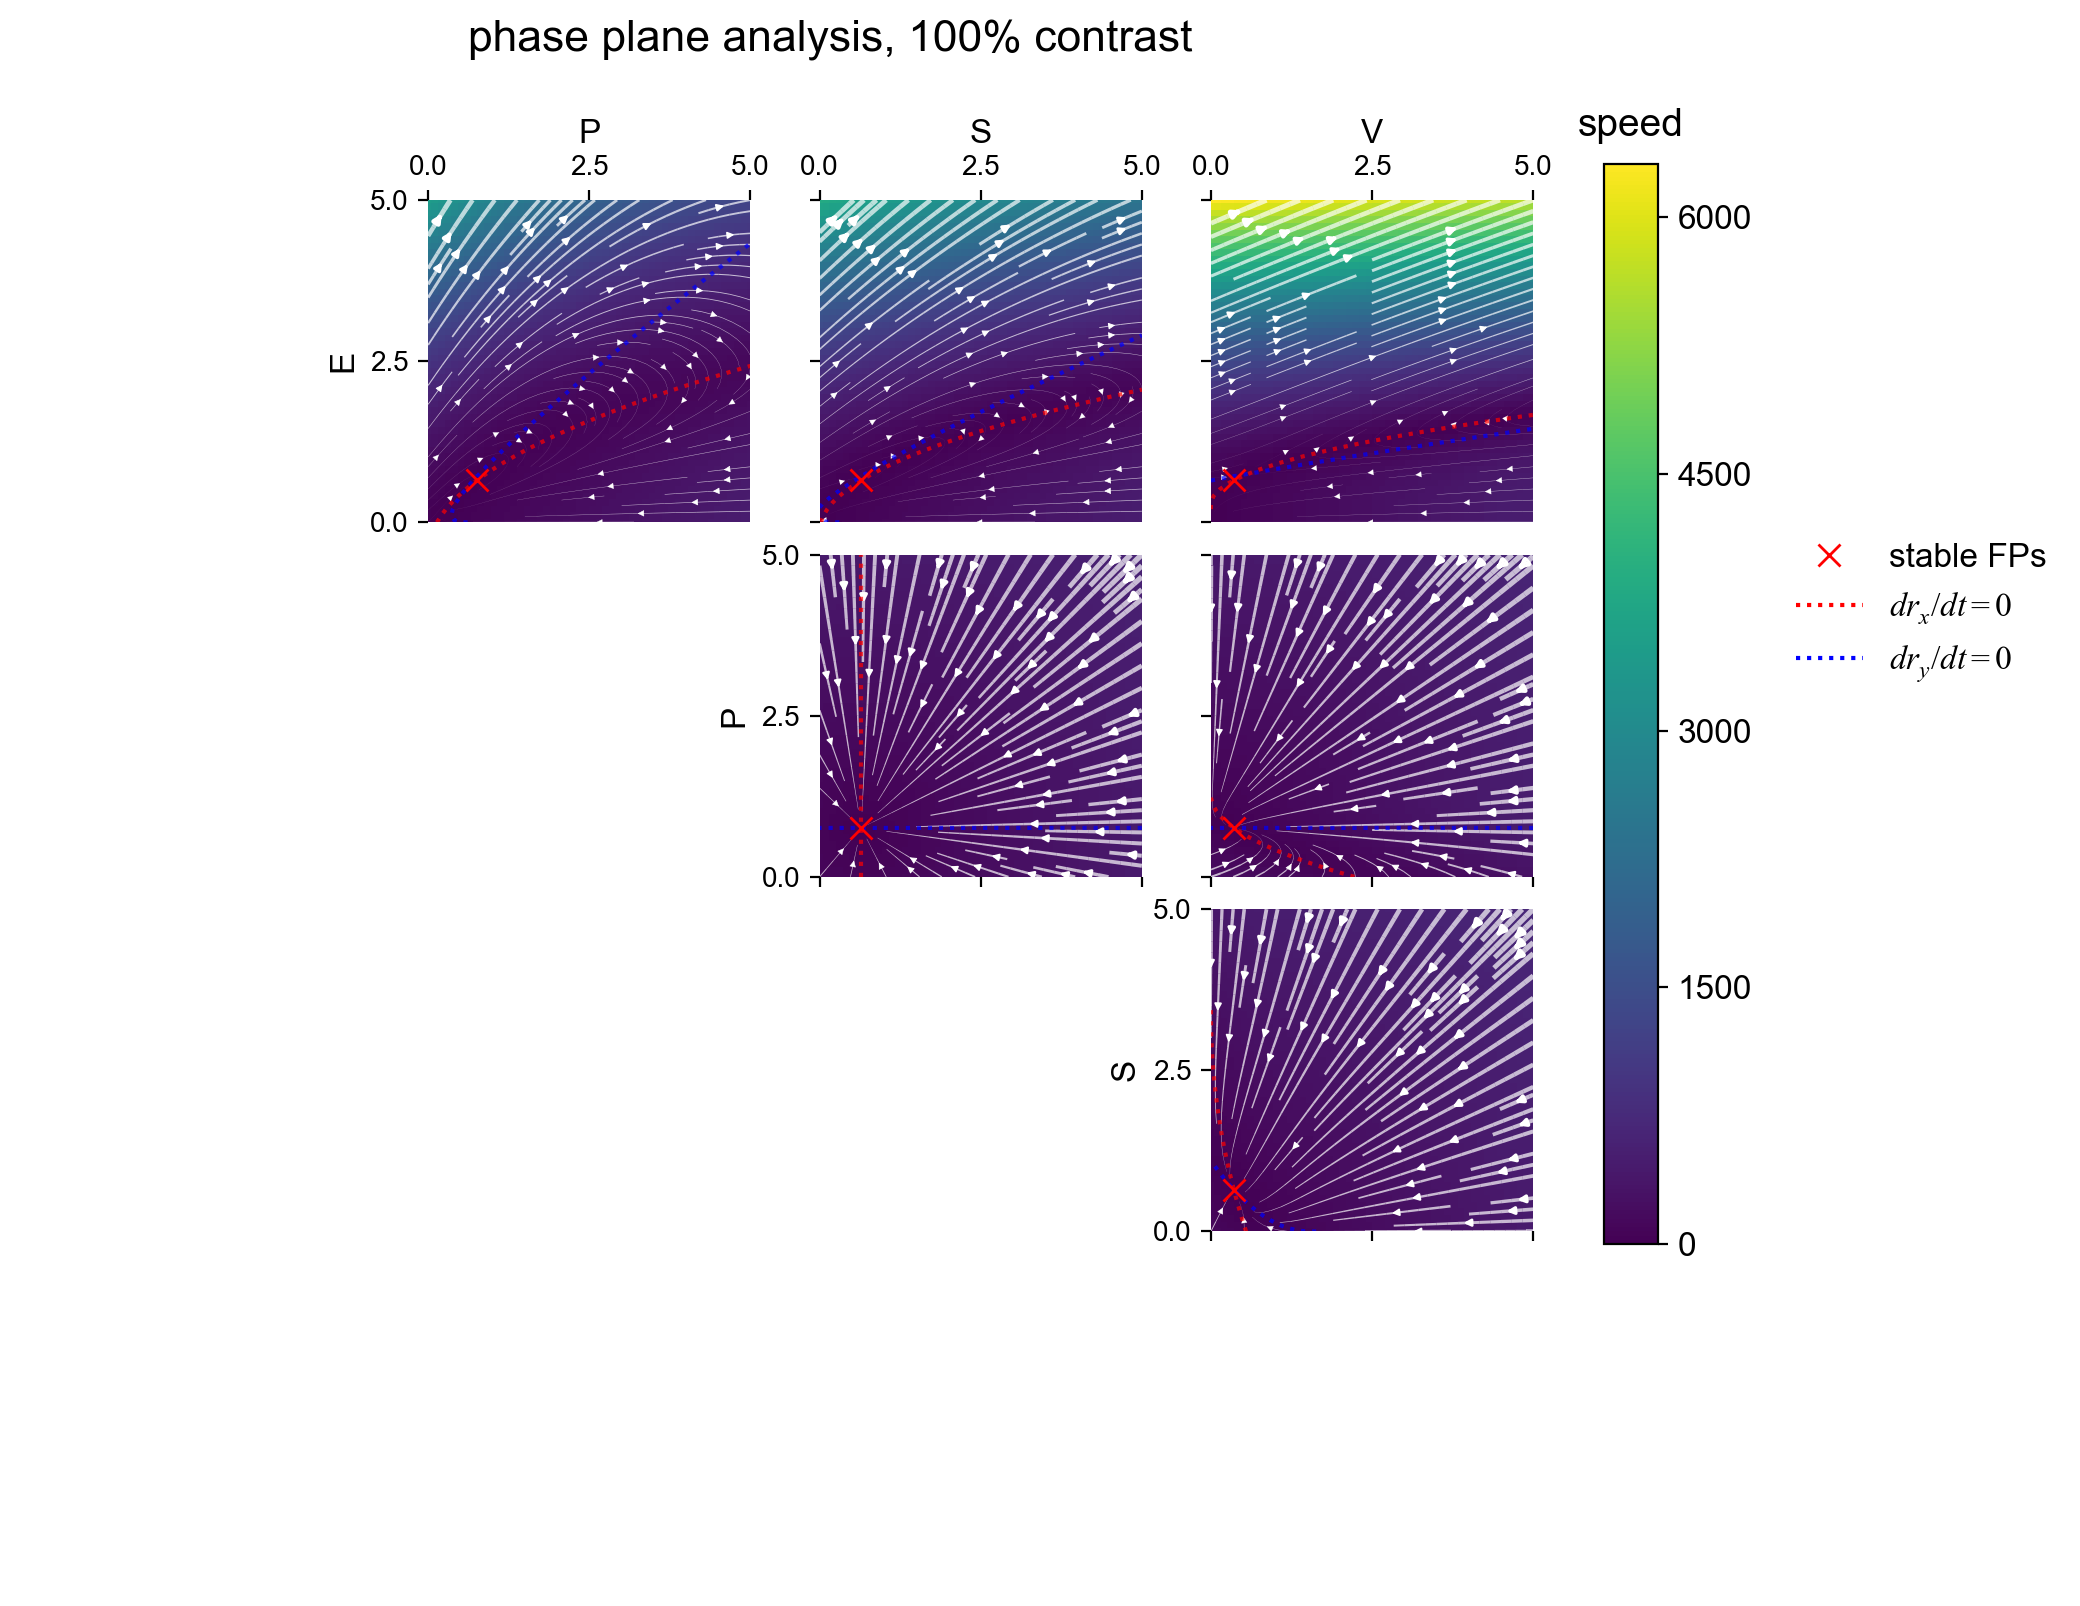

In [ ]:
# combinations of phase planes for single fit/contrast

k = 3
contrast = 1
W, h1, h0 = top_params[k]
h_ext = np.array([0, 0, 0, 2])
h0_tot = h0 + h_ext
h_tot = h1 * contrast + h0_tot
x_lims = (0, 5)
y_lims = (0, 5)

_, r_fp_list, *_ = get_fit_poly_1(W, h1, h0_tot, contrast, c_range, means, N_z=10000000) # r_fp_list_refined = [lambda]
fig, axes = plot_upper_triangular_phase_planes(W, h1, h0, h_ext, contrast, TAU, x_lims, y_lims, k, variable_labels=None, r_fp_list=r_fp_list, resolution=50, savefig=False)